# Assessing quality of assemblies
There are assemblies for nine samples being assessed here.

These samples have >= 30x coverage of PacBio CCS. As well as good coverage Illumina and Nanopore.

There are five assembly tools being analysed, with an assembly for each Nanopore and PacBio. Except for Spades, which takes all sequencing technologies at once.

The polishing is done in two steps:
1. Polish assembly with the long reads it was made from using `racon`
2. Polish the output of `racon` with Illumina using `pilon` until there is no more changes made to the assembly.

In [44]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import DefaultDict
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from dataclasses import dataclass

plt.style.use("ggplot")
FIGSIZE = (13, 8)

In [45]:
nord = [
    "#2e3440", 
    "#3b4252", 
    "#434c5e", 
    "#4c566a", 
    "#d8dee9", 
    "#e5e9f0", 
    "#eceff4", 
    "#8fbcbb", 
    "#88c0d0", 
    "#81a1c1", 
    "#5e81ac", 
    "#bf616a", 
    "#d08770",
    "#ebcb8b",
    "#a3be8c",
    "#b48ead",
]
polar_night = nord[:4]
snow_storm = nord[4:7]
frost = nord[7:11]
aurora = nord[11:]

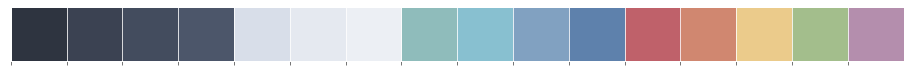

In [46]:
sns.palplot(nord)

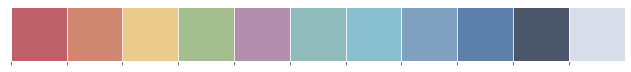

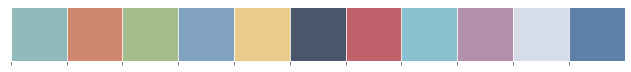

In [47]:
nord_pal = [*aurora, *frost, polar_night[-1], snow_storm[0]]
sns.palplot(nord_pal)
idxs = [5, 1, 3, 7, 2, 9, 0, 6, 4, 10, 8]
nord_pal = sns.color_palette([nord_pal[i] for i in idxs])
sns.palplot(nord_pal)
# sns.set_palette(nord_pal)

In [29]:
@dataclass(eq=True, frozen=True)
class Sample:
    name: str
    assembler: str
    technology: str
    is_polished: bool
    
    @staticmethod
    def from_path(path: Path) -> "Sample":
        parts = path.parts
        is_polished = "polished" in path.name
        return Sample(
            name = parts[-5],  # we index from end in case starting path is further up dirtree
            assembler = parts[-4],
            technology = parts[-3],
            is_polished = is_polished
        )

In [30]:
results_dir = Path("../results")
assessment_files = list(results_dir.rglob("*mada*.json"))
ale_files = list(results_dir.rglob("*.aggregated.ale"))

In [31]:
len(assessment_files)

162

In [32]:
len(ale_files)

18

In [33]:
scores: DefaultDict[Sample, float] = defaultdict(Sample)
for file in ale_files:
    with file.open() as fh:
        for line in map(str.strip, fh):
            path, score = line.split(":")
            sample = Sample.from_path(Path(path))
            score = float(score)
            scores[sample] = score

In [34]:
data = []

In [35]:
for file in assessment_files:
    sample = Sample.from_path(file)
    arr = [
        sample.name,
        sample.assembler,
        sample.technology,
        sample.is_polished,
    ]
    arr.append(scores[sample])
    d = json.loads(file.read_text())
    mapq = d["mapping_quality_stats"]
    pileup = d["pileup_stats"]
    arr.extend([
        pileup["percent_pileup_disagree"],
        pileup["total_disagreements"],
        pileup["total_pileup_positions"],
        [
            mapq["min"], mapq["25%"], mapq["50%"], mapq["75%"], mapq["max"]
        ],
        mapq["mean"],
        mapq["std"]
    ])
    data.append(arr)

In [36]:
columns = [
    "sample",
    "assembler",
    "technology",
    "is_polished",
    "ale_score",
    "disagree_rate",
    "disagreements",
    "total_positions",
    "mapq_percentiles",
    "mapq_mean",
    "mapq_stdev",
]
df = pd.DataFrame(data, columns=columns).drop(columns=["mapq_percentiles"])

# ALE score
> [ALE: a generic assembly likelihood evaluation framework for assessing the accuracy of genome and metagenome assemblies][ale_paper]

We are using `ALE` here to assess which of the assemblies is the most accurate (has the highest ALE score). For a rigorous definition of the ALE score, refer to the [methods section][ale_methods].

Of note:

> The ALE score can be used to compare two different assemblies of the same genome, forumla and forumla⁠. Call forumla⁠, the ALE score of the first assembly, and forumla⁠, the ALE score of the second, both generated from the same set of reads forumla⁠. The difference of these scores is then given by the equation  

\begin{equation*}
A_1 - A_2 = \log{\frac{P(S_1|R)}{P(S_2|R)}}
\end{equation*}

> The assembly with the higher ALE score is also the one with the larger probability of being correct. Moreover, the difference between two assemblies’ ALE scores describes their relative probabilities of correctness. Below, we refer to the ALE score more precisely as the total ALE score, to differentiate it from the sub-scores (described later in the text) used to construct it.

> Although the ALE score can be reported as a standalone value, this is made possible only to facilitate comparisons with other assemblies of the same genome. We emphasize that the ALE score is a comparative measure and should not be used to judge the quality of a single assembly in isolation

**So, we are looking to see what assembly has the *highest* ALE score.**

[ale_paper]: https://doi.org/10.1093/bioinformatics/bts723
[ale_methods]: https://academic.oup.com/bioinformatics/article/29/4/435/199222#130434587

Now because the ALE scores are only relevant *within* the same sample, we will need to normalise them for each sample. We do this by taking each sample's maximum score and subtracting all other scores (for the sample) from it.

In [37]:
df["norm_ale_score"] = df.groupby("sample")["ale_score"].transform(lambda x: x.max() - x)   

Let's take a look at which combinations have the highest ALE score for each sample.

In [38]:
df.query("norm_ale_score == 0")

,sample,assembler,technology,is_polished,ale_score,disagree_rate,disagreements,total_positions,mapq_mean,mapq_stdev,norm_ale_score
14,mada_1-2,canu,pacbio,True,-7.362752e+08,5.353265,236159,4411495,33.990839,29.114382,0.0
25,mada_104,flye,pacbio,False,-4.623904e+07,0.616207,27188,4412157,58.969137,7.436640,0.0
44,mada_101,flye,nanopore,True,-2.852360e+07,0.413026,18298,4430233,59.150055,6.769707,0.0
62,mada_1-44,flye,nanopore,True,-2.048224e+07,1.067497,47182,4419871,59.344411,5.877490,0.0
79,mada_130,flye,pacbio,True,-2.868194e+07,0.706765,31158,4408535,58.979803,7.513433,0.0
97,mada_132,flye,pacbio,True,-1.715299e+07,0.998215,43862,4394043,59.243372,6.428447,0.0
110,mada_116,unicycler,pacbio,False,-2.658962e+07,0.434147,19214,4425691,59.072402,7.123947,0.0
126,mada_125,spades,pacbio,True,-1.848009e+07,0.537077,23702,4413147,59.133411,6.864277,0.0
144,mada_102,spades,pacbio,False,-1.835982e+07,0.467174,20586,4406491,59.213578,6.552905,0.0


And to summarise the counts for how many times the **assembler** has the highest ALE score

In [39]:
df.query("norm_ale_score == 0").groupby("assembler")["sample"].count()

assembler
canu         1
flye         5
spades       2
unicycler    1
Name: sample, dtype: int64

And to summarise the counts for how many times the **technology** has the highest ALE score

In [40]:
df.query("norm_ale_score == 0").groupby("technology")["sample"].count()

technology
nanopore    2
pacbio      7
Name: sample, dtype: int64

And to summarise the counts for how many times the **polished** has the highest ALE score

In [41]:
df.query("norm_ale_score == 0").groupby("is_polished")["sample"].count()

is_polished
False    3
True     6
Name: sample, dtype: int64

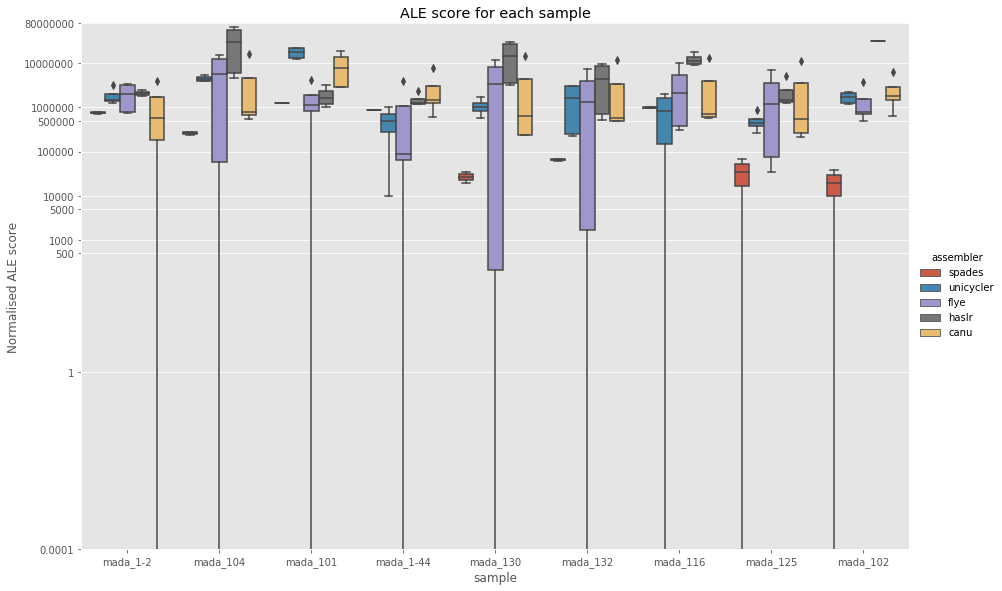

In [50]:
x = "sample"
y = "norm_ale_score"
hue = "assembler"
kind = "box"
aspect = 1.5
height = 8
ax = sns.catplot(
    x=x,
    y=y, 
    hue=hue,
    data=df, 
    kind=kind, 
    aspect=aspect, 
    height=height,
)
ax.set(yscale="log")
ax.set(title="ALE score for each sample")
log_ticks = [0.0001, 1, 500, 1_000, 5_000, 10_000, 100_000, 500_000, 1_000_000, 10_000_000, 80_000_000]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Normalised ALE score")
_ = ax.set_yticklabels(log_ticks)

# Disagreement rate
The first metric we will look at is disagreement rate. This is a "proxy" for per-base accuracy of our assemblies. As we don't have a ground-truth for these samples, we need some kind of metric that gives us an indication of the accuracy.  
Disagreement rate is calculated by mapping Illumina reads (with `bwa mem`) for a given sample to the unpolished and polished assemblies of that sample.

## Plot sample disagreement rate

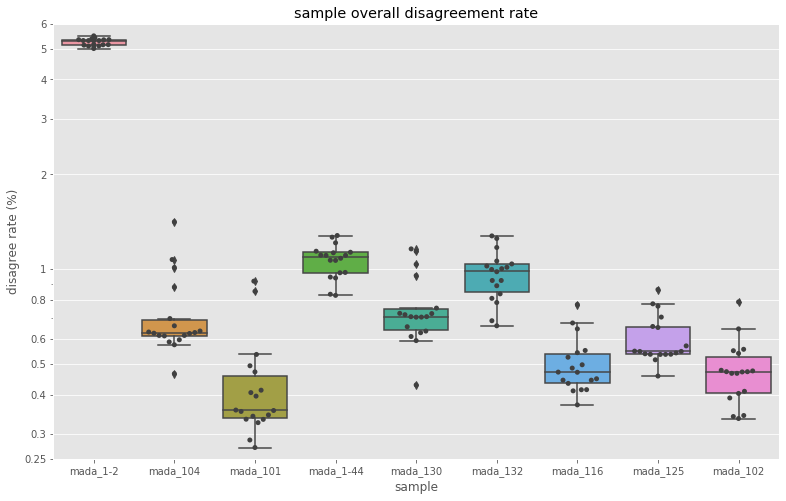

In [51]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="sample overall disagreement rate")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)


## Plot sample (un)polished disagreement rate


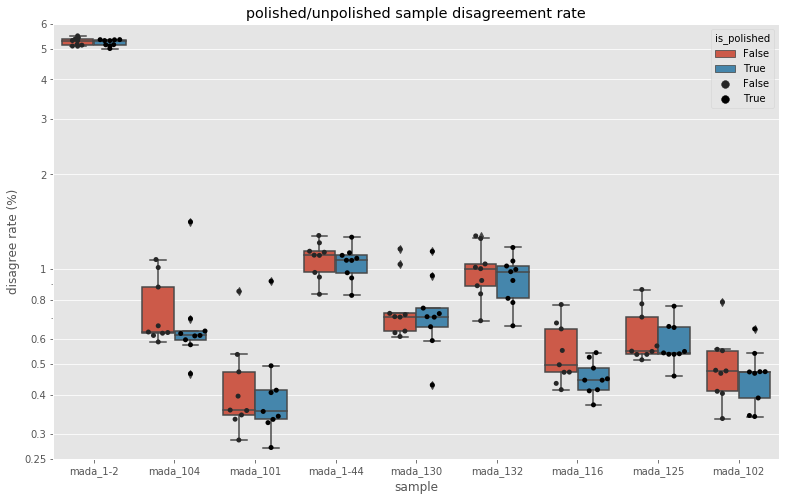

In [56]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax,
    dodge=True,
    color="black"
)
ax.set_yscale("log")
ax.set(title="polished/unpolished sample disagreement rate")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

So, on the whole, polishing reduces the disagreement rate.


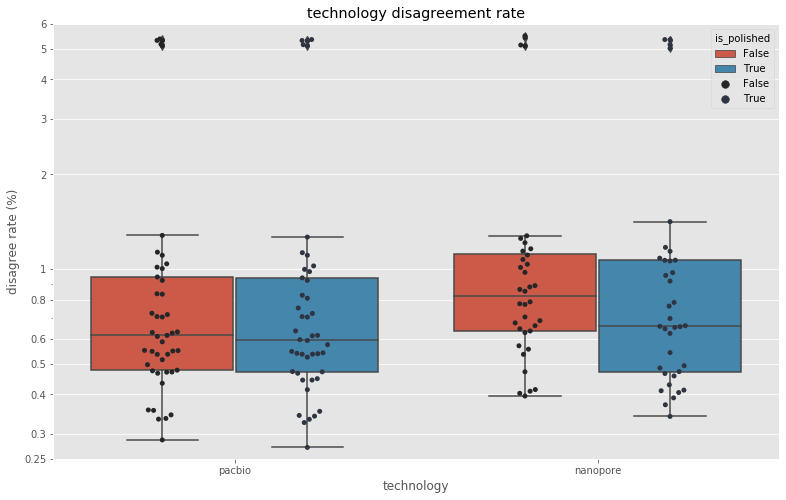

In [60]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="technology", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax
)
ax = sns.swarmplot(
    x="technology", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set_yscale("log")
ax.set(title="technology disagreement rate")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

This shows that polished has much more effect on the nanopore assemblies then it does on the pacbio ones.

## Plot disagreement rate for each assembler

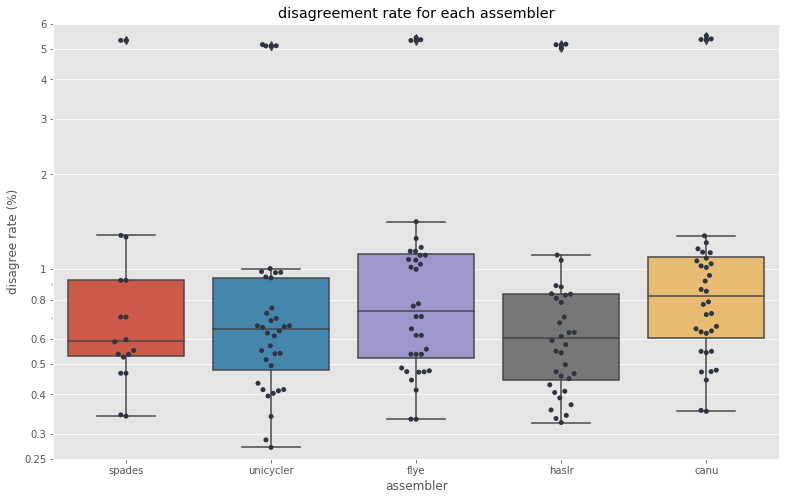

In [61]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    data=df, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set_yscale("log")
ax.set(title="disagreement rate for each assembler")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

## Plot disagreement rate for each assembler, split by technology

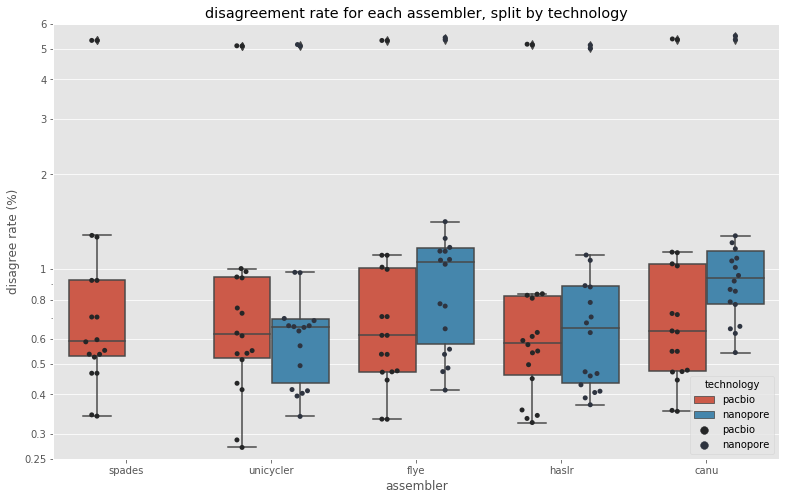

In [62]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=df, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set_yscale("log")
ax.set(title="disagreement rate for each assembler, split by technology")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

Ok. So it's fairly clear that `unicycler` handles nanopore much better than it does pacbio. `flye` is better on pacbio data (v2.7 introduced a new "hifi" mode). `haslr` and `canu` perform about the same on each.

What if we look at each sample split but technology?

## Plot disagreement rate for each sample, split by technology

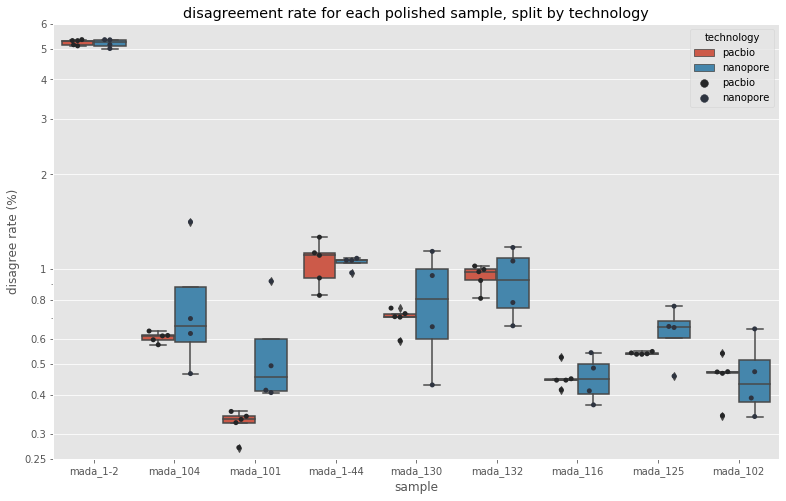

In [63]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == True"), 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == True"), 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title="disagreement rate for each polished sample, split by technology")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

On the whole, pacbio data produces less disagreements. However, there are a couple of samples where it is the same between both, and maybe even one where nanopore appears to be better (mada_102).

Let's have a look at the same plot, but the unpolished data.

## Plot disagreement rate for each sample (**unpolished**), split by technology


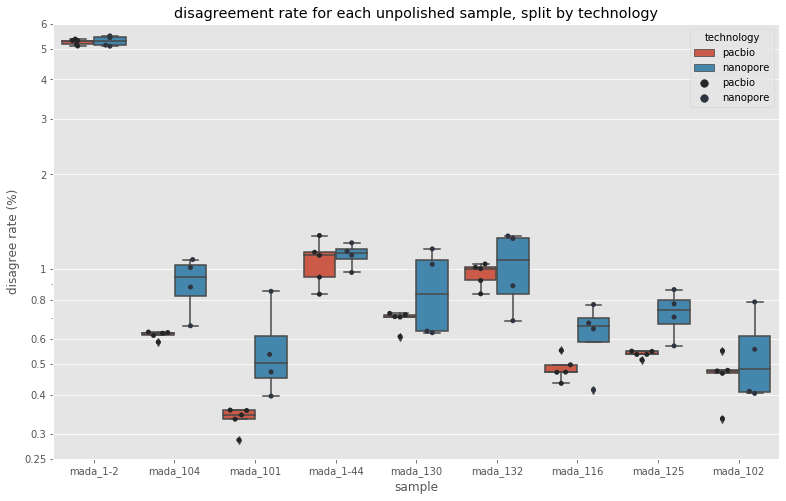

In [64]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == False"), 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == False"), 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title="disagreement rate for each unpolished sample, split by technology")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

Ok, so moral of the story: PacBio (CCS) assemblies are better than nanopore if you can't polish.

Let's have a look at each assembler, split by sample

## Plot disagreement rate for each assembler, split by sample

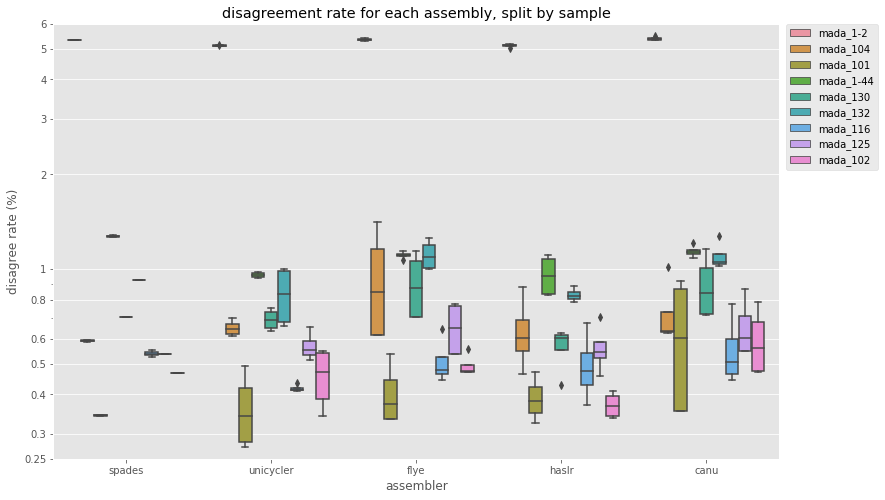

In [65]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="sample",
    data=df, 
    ax=ax
)
ax.set(title="disagreement rate for each assembly, split by sample")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

## One plot to rule them all

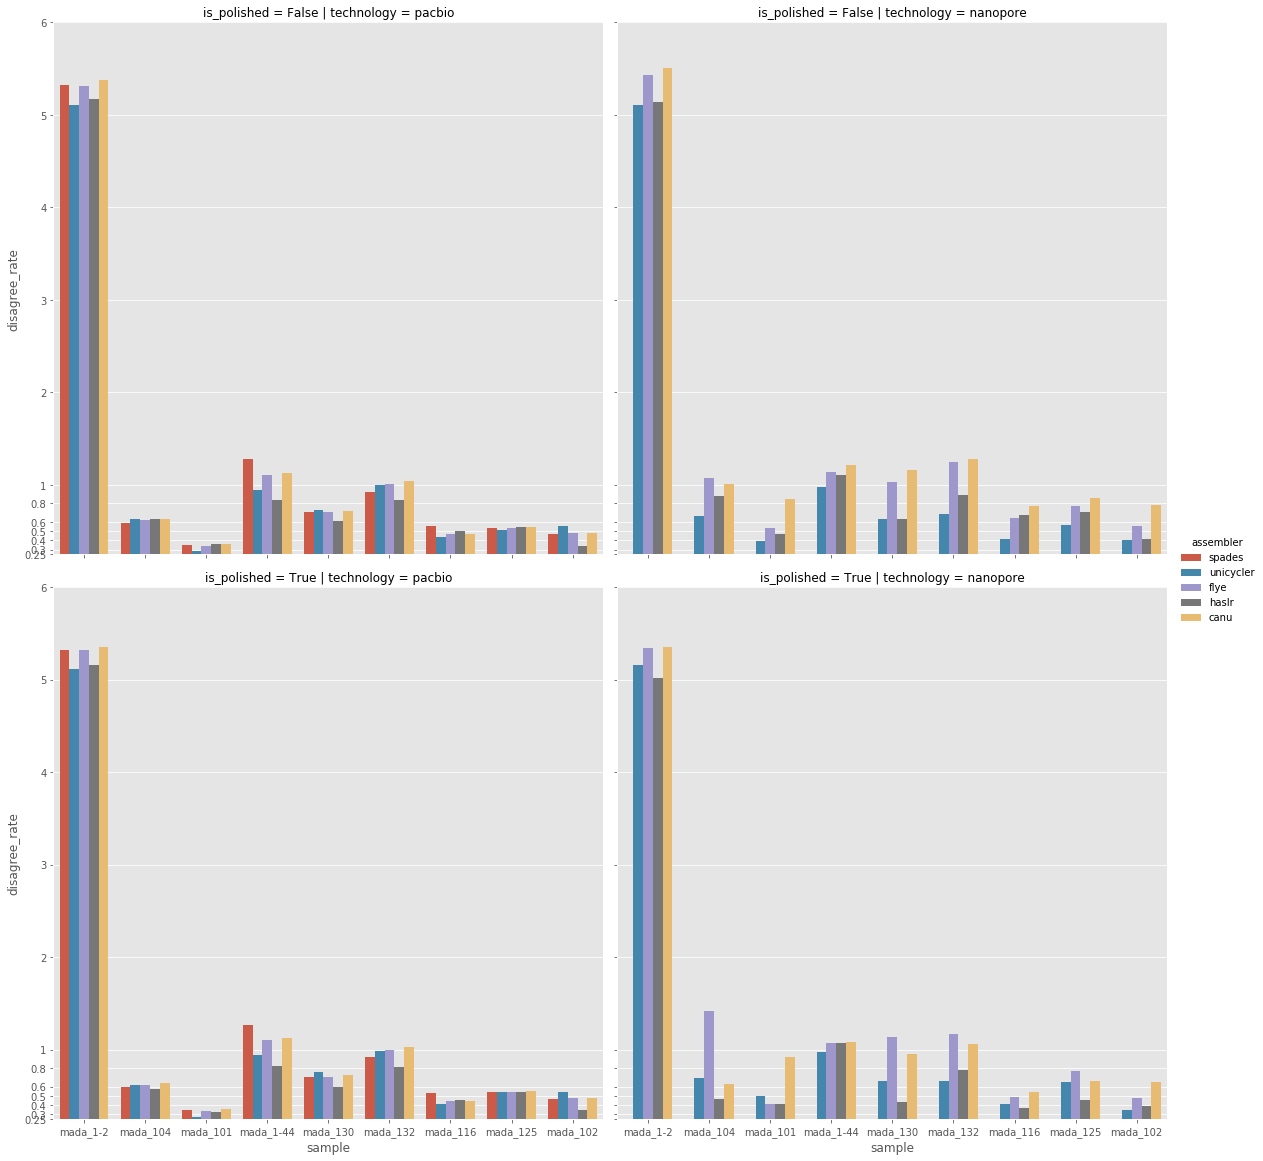

In [66]:
ax = sns.catplot(
    x="sample", 
    y="disagree_rate", 
    hue="assembler",
    col="technology",
    row="is_polished",
    data=df, 
    kind="bar", 
    aspect=1, 
    height=8
)
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
_ = ax.set_yticklabels(log_ticks)

### Disagreement rate conclusion


In [67]:
df.loc[df.groupby('sample', sort=False)['disagree_rate'].idxmin()]

,sample,assembler,technology,is_polished,ale_score,disagree_rate,disagreements,total_positions,mapq_mean,mapq_stdev,norm_ale_score
12,mada_1-2,haslr,nanopore,True,-7.380833e+08,5.015515,218334,4353172,34.169674,29.086532,1.808084e+06
30,mada_104,haslr,nanopore,True,-1.014992e+08,0.466260,19525,4187577,57.241020,12.250603,5.526017e+07
38,mada_101,unicycler,pacbio,True,-5.035158e+07,0.271666,11762,4329578,57.892122,10.856701,2.182798e+07
64,mada_1-44,haslr,pacbio,True,-2.171400e+07,0.825899,36356,4401993,59.285617,6.227048,1.231759e+06
84,mada_130,haslr,nanopore,True,-5.426202e+07,0.429275,18328,4269528,58.024631,10.553018,2.558007e+07
94,mada_132,unicycler,nanopore,True,-2.019927e+07,0.661242,28842,4361793,59.215760,6.540229,3.046276e+06
121,mada_116,haslr,nanopore,True,-3.919394e+07,0.371018,16208,4368522,58.595969,8.827607,1.260432e+07
138,mada_125,haslr,nanopore,True,-1.981836e+07,0.458021,20147,4398704,59.096972,7.004769,1.338271e+06
155,mada_102,haslr,pacbio,False,-5.004062e+07,0.335769,14302,4259480,57.326404,12.211989,3.168079e+07


In [68]:
df.loc[df.groupby('sample', sort=False)['disagree_rate'].idxmin()].groupby("assembler")["sample"].count()

assembler
haslr        7
unicycler    2
Name: sample, dtype: int64

In [69]:
df.loc[df.groupby('sample', sort=False)['disagree_rate'].idxmin()].groupby("is_polished")["sample"].count()

is_polished
False    1
True     8
Name: sample, dtype: int64

In [70]:
df.loc[df.groupby('sample', sort=False)['disagree_rate'].idxmin()].groupby("technology")["sample"].count()

technology
nanopore    6
pacbio      3
Name: sample, dtype: int64

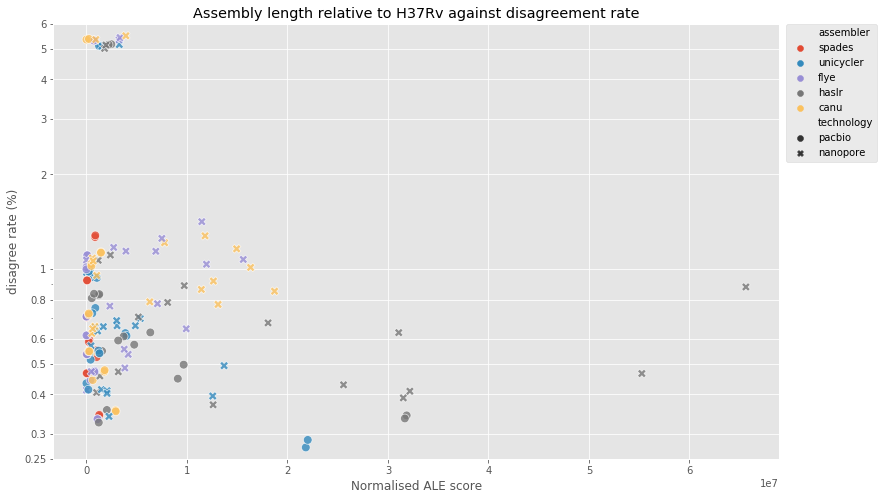

In [71]:
x = "norm_ale_score"
y = "disagree_rate"
hue = "assembler"
style = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.scatterplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    style=style,
    ax=ax,
    s=75,
    alpha=0.8
)
ax.set(title="Assembly length relative to H37Rv against disagreement rate")
_ = ax.set_xlabel("Normalised ALE score")
# ax.set_xscale("log")
ax.set_yscale("log")

log_ticks = [0, 1, 500, 1_000, 5_000, 10_000, 100_000, 500_000, 1_000_000, 10_000_000, 80_000_000]
# ax.set_xticks(log_ticks)
# _ = ax.set_xticklabels(log_ticks)
# _ = ax.set_xlim((log_ticks[0], log_ticks[-1]))
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

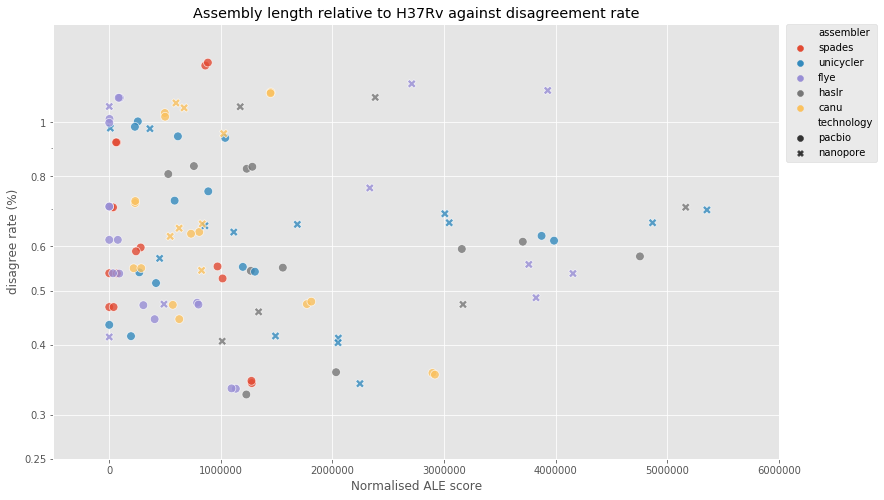

In [72]:
x = "norm_ale_score"
y = "disagree_rate"
hue = "assembler"
style = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.scatterplot(
    x=x, 
    y=y, 
    data=df, 
    hue=hue,
    style=style,
    ax=ax,
    s=75,
    alpha=0.8
)
ax.set(title="Assembly length relative to H37Rv against disagreement rate")
_ = ax.set_xlabel("Normalised ALE score")
# ax.set_xscale("log")
ax.set_yscale("log")

log_ticks = [0, 1, 500, 1_000, 5_000, 10_000, 100_000, 500_000, 1_000_000, 10_000_000, 80_000_000]
# ax.set_xticks(log_ticks)
# _ = ax.set_xticklabels(log_ticks)
_ = ax.set_xlim((-5e5, 0.6e7))
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 6]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], 1.5))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Quast metrics

In [74]:
quast_files = list(results_dir.rglob("report.tsv"))
len(quast_files)

9

In [75]:
frames = []
cols_to_keep = [
    "# contigs", "Largest contig", "Total length", "GC (%)", "Avg. coverage depth", 
    "# misassemblies", "# mismatches per 100 kbp", "# indels per 100 kbp", "# genomic features",
]
names = [
    "contigs", "largest_contig", "total_length", "gc", "avg_depth", "misassemblies", 
    "mismatch_rate", "indel_rate", "genomic_features"
]
for file in quast_files:
    sample = file.parts[-3]
    d = pd.read_csv(file, sep="\t").T
    d.columns = d.iloc[0]
    d = d[1:]
    d = d[cols_to_keep]
    d.columns = names
    d.genomic_features = [int(x.split()[0]) for x in d.genomic_features]
    d["sample"] = sample
    frames.append(d)

In [76]:
quast_df = pd.concat(frames)

In [77]:
asm_dict = {
    "uc": "unicycler",
    "flye": "flye",
    "haslr": "haslr",
    "spades": "spades",
    "canu": "canu"
}
is_polished = []
assembler = []
technology = []
for i in quast_df.index:
    parts = i.split("_")
    is_polished.append("pol" in parts)
    assembler.append(asm_dict[parts[0]])
    technology.append("nanopore" if "ont" in parts else "pacbio")

In [78]:
quast_df["is_polished"] = is_polished
quast_df["assembler"] = assembler
quast_df["technology"] = technology


In [79]:
for c in quast_df.columns[:8]:
    quast_df[c] = pd.to_numeric(quast_df[c])
quast_df.reset_index(inplace=True)

## Number of contigs

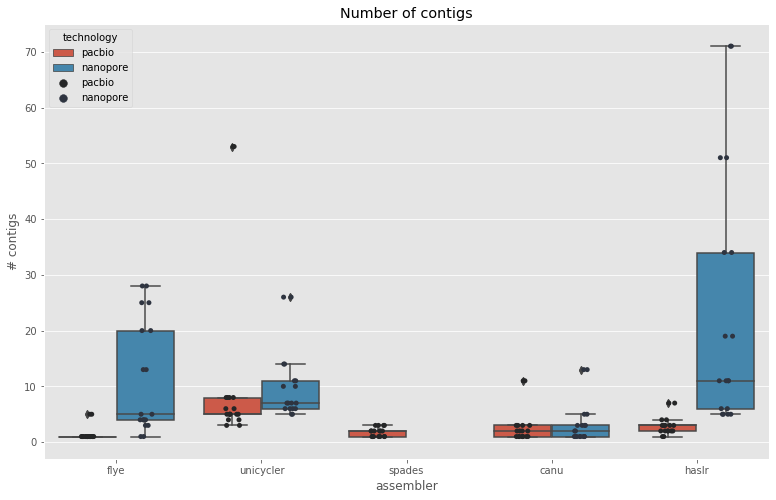

In [134]:
x = "assembler"
y = "contigs"
hue = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=quast_df, 
    hue=hue,
    ax=ax
)
ax = sns.stripplot(
    x=x, 
    y=y, 
    hue=hue,
    data=quast_df, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title="Number of contigs")
_ = ax.set_ylabel("# contigs")

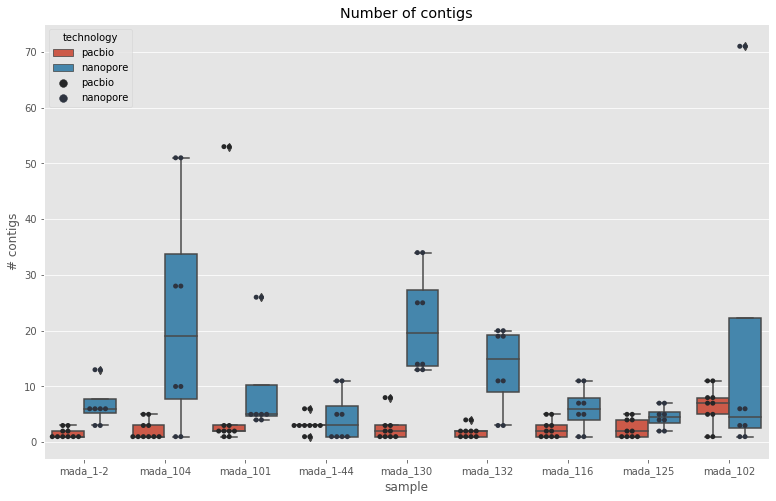

In [85]:
x = "sample"
y = "contigs"
hue = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=quast_df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=quast_df, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title="Number of contigs")
_ = ax.set_ylabel("# contigs")

In [86]:
for sample, frame in quast_df.groupby("sample"):
    print(f"------{sample}------\n")
    m = frame["contigs"].min()
    print(f"Minimum {m} contigs")
    print(frame.query("contigs == @m").groupby("assembler")["sample"].count())
quast_df.query("contigs == 1").groupby("assembler")["sample"].count()

------mada_1-2------

Minimum 1 contigs
assembler
canu      2
flye      2
spades    2
Name: sample, dtype: int64
------mada_1-44------

Minimum 1 contigs
assembler
canu    2
flye    4
Name: sample, dtype: int64
------mada_101------

Minimum 1 contigs
assembler
flye    2
Name: sample, dtype: int64
------mada_102------

Minimum 1 contigs
assembler
canu      2
spades    2
Name: sample, dtype: int64
------mada_104------

Minimum 1 contigs
assembler
canu     4
flye     2
haslr    2
Name: sample, dtype: int64
------mada_116------

Minimum 1 contigs
assembler
canu    4
flye    2
Name: sample, dtype: int64
------mada_125------

Minimum 1 contigs
assembler
flye      2
spades    2
Name: sample, dtype: int64
------mada_130------

Minimum 1 contigs
assembler
flye      2
spades    2
Name: sample, dtype: int64
------mada_132------

Minimum 1 contigs
assembler
canu    2
flye    2
Name: sample, dtype: int64


assembler
canu      16
flye      18
haslr      2
spades     8
Name: sample, dtype: int64

In [87]:
quast_df.query("contigs == 1").groupby("technology")["sample"].count()

technology
nanopore    10
pacbio      34
Name: sample, dtype: int64

## Total length


Relative length here is defined as **the absolute value of the assembly length minus the length of H37Rv**.

We also show the positions with respect to H37Rv - without normalisation. 

In [88]:
h37rv_len = 4_411_532
quast_df["relative_total_length"] = np.absolute((quast_df["total_length"] - h37rv_len) / 1000)

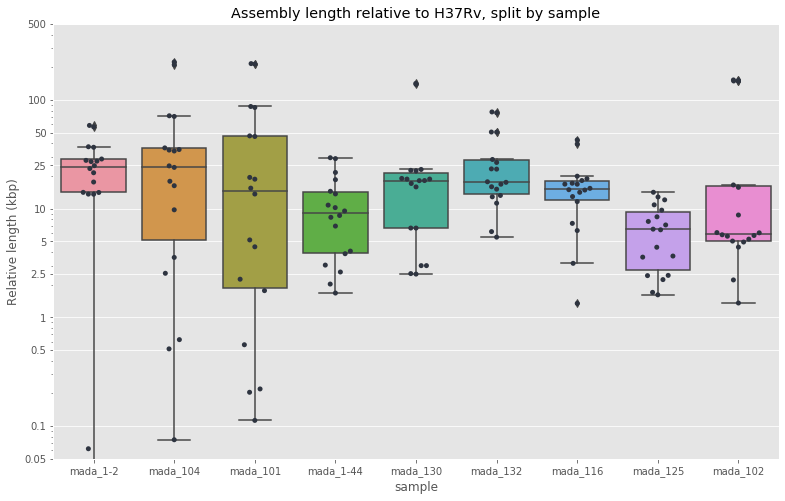

In [89]:
x = "sample"
y = "relative_total_length"
data = quast_df
title = "Assembly length relative to H37Rv, split by sample"
ylabel = "Relative length (kbp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

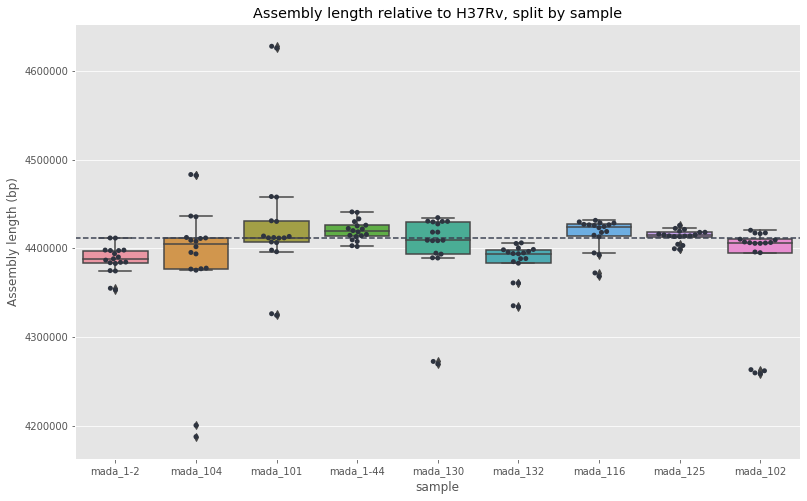

In [90]:
x = "sample"
y = "total_length"
data = quast_df
title = "Assembly length relative to H37Rv, split by sample"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])

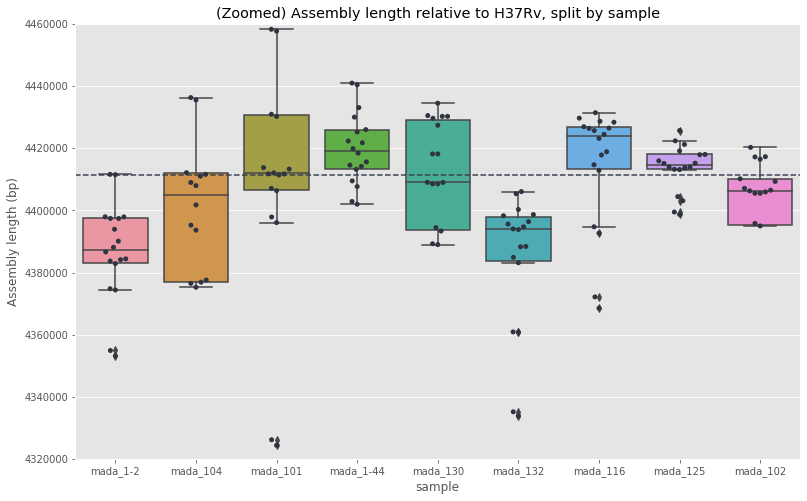

In [91]:
x = "sample"
y = "total_length"
data = quast_df
title = "(Zoomed) Assembly length relative to H37Rv, split by sample"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
_ = ax.set_ylim((4_320_000, 4_460_000))

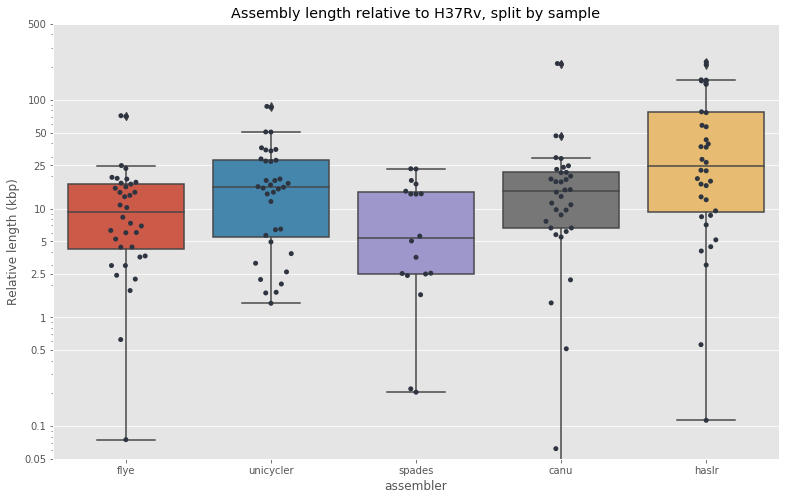

In [92]:
x = "assembler"
y = "relative_total_length"
data = quast_df
title = "Assembly length relative to H37Rv, split by sample"
ylabel = "Relative length (kbp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

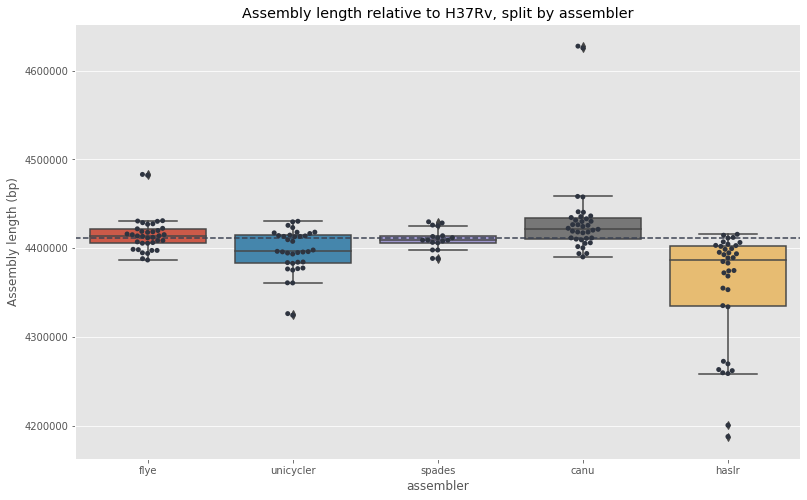

In [93]:
x = "assembler"
y = "total_length"
data = quast_df
title = "Assembly length relative to H37Rv, split by assembler"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])

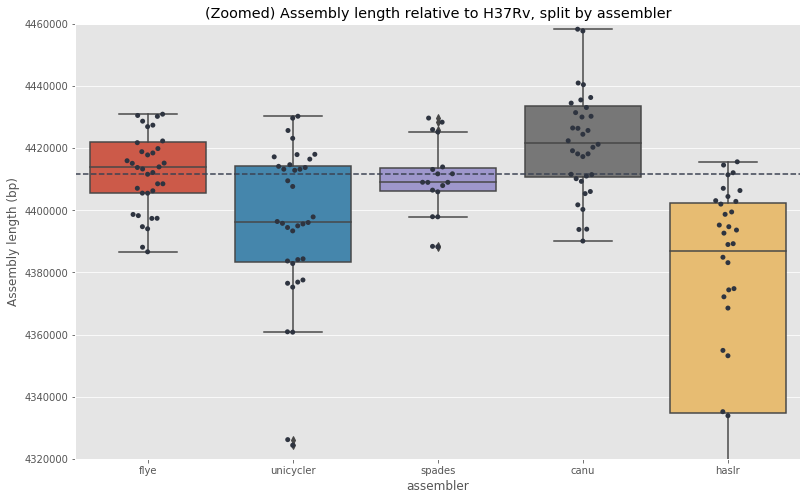

In [94]:
x = "assembler"
y = "total_length"
data = quast_df
title = "(Zoomed) Assembly length relative to H37Rv, split by assembler"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
_ = ax.set_ylim((4_320_000, 4_460_000))

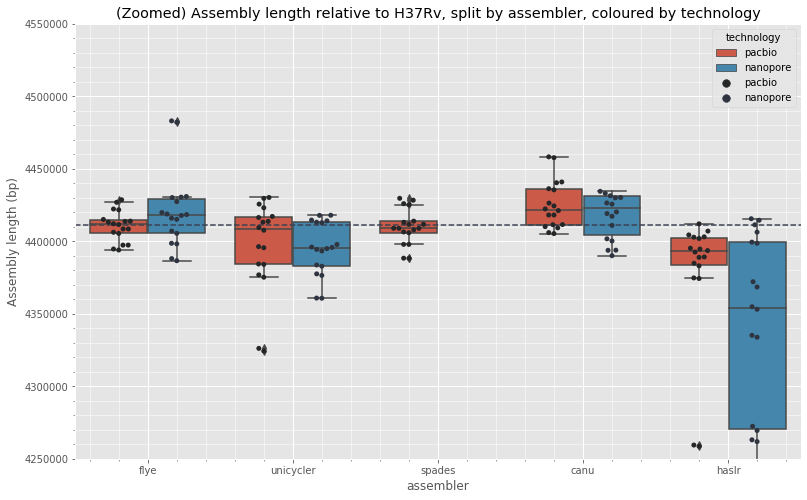

In [98]:
x = "assembler"
y = "total_length"
hue = "technology"
data = quast_df
title = f"(Zoomed) Assembly length relative to H37Rv, split by {x}, coloured by {hue}"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
_ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
# _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [137]:
data

,index,contigs,largest_contig,total_length,gc,avg_depth,misassemblies,mismatch_rate,indel_rate,genomic_features,sample,is_polished,assembler,technology,relative_total_length
0,flye_pb,1,4397424,4397424,65.62,282,30,23.05,3.35,8309,mada_1-2,False,flye,pacbio,14.108
1,flye_pb_pol,1,4397389,4397389,65.62,282,30,55.60,4.16,8301,mada_1-2,True,flye,pacbio,14.143
2,flye_ont,13,1234447,4388113,65.60,187,30,51.56,55.91,8257,mada_1-2,False,flye,nanopore,23.419
3,flye_ont_pol,13,1233661,4386635,65.63,187,30,150.99,22.95,8234,mada_1-2,True,flye,nanopore,24.897
4,uc_pb,3,2201689,4384128,65.58,187,30,24.47,3.71,8286,mada_1-2,False,unicycler,pacbio,27.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,canu_ont_pol,1,4420286,4420286,65.64,444,43,34.68,8.03,8250,mada_102,True,canu,nanopore,8.754
158,haslr_pb,7,1176786,4259480,65.56,446,40,28.52,5.58,7998,mada_102,False,haslr,pacbio,152.052
159,haslr_pb_pol,7,1176771,4258616,65.56,446,40,27.04,4.26,7992,mada_102,True,haslr,pacbio,152.916
160,haslr_ont,71,157193,4263109,65.58,449,34,27.79,12.07,7910,mada_102,False,haslr,nanopore,148.423


In [138]:
df

,sample,assembler,technology,is_polished,ale_score,disagree_rate,disagreements,total_positions,mapq_mean,mapq_stdev,norm_ale_score
0,mada_1-2,spades,pacbio,True,-7.369880e+08,5.316559,233817,4397901,34.090227,29.098865,7.127768e+05
1,mada_1-2,spades,pacbio,False,-7.370768e+08,5.318908,233922,4397933,34.087307,29.099658,8.015972e+05
2,mada_1-2,unicycler,pacbio,False,-7.376974e+08,5.108405,223959,4384128,34.060488,29.107869,1.422228e+06
3,mada_1-2,unicycler,pacbio,True,-7.375268e+08,5.114177,224225,4384381,34.079517,29.101268,1.251633e+06
4,mada_1-2,unicycler,nanopore,True,-7.395444e+08,5.160099,226160,4382862,34.207912,29.081119,3.269211e+06
...,...,...,...,...,...,...,...,...,...,...,...
157,mada_102,haslr,nanopore,False,-5.054008e+07,0.409701,17466,4263109,57.682653,11.353692,3.218026e+07
158,mada_102,canu,pacbio,True,-2.013043e+07,0.472885,20851,4409319,59.003111,7.406676,1.770604e+06
159,mada_102,canu,pacbio,False,-2.017030e+07,0.477759,21070,4410174,59.000995,7.411132,1.810473e+06
160,mada_102,canu,nanopore,False,-2.466251e+07,0.787224,34774,4417292,59.122493,6.906751,6.302681e+06


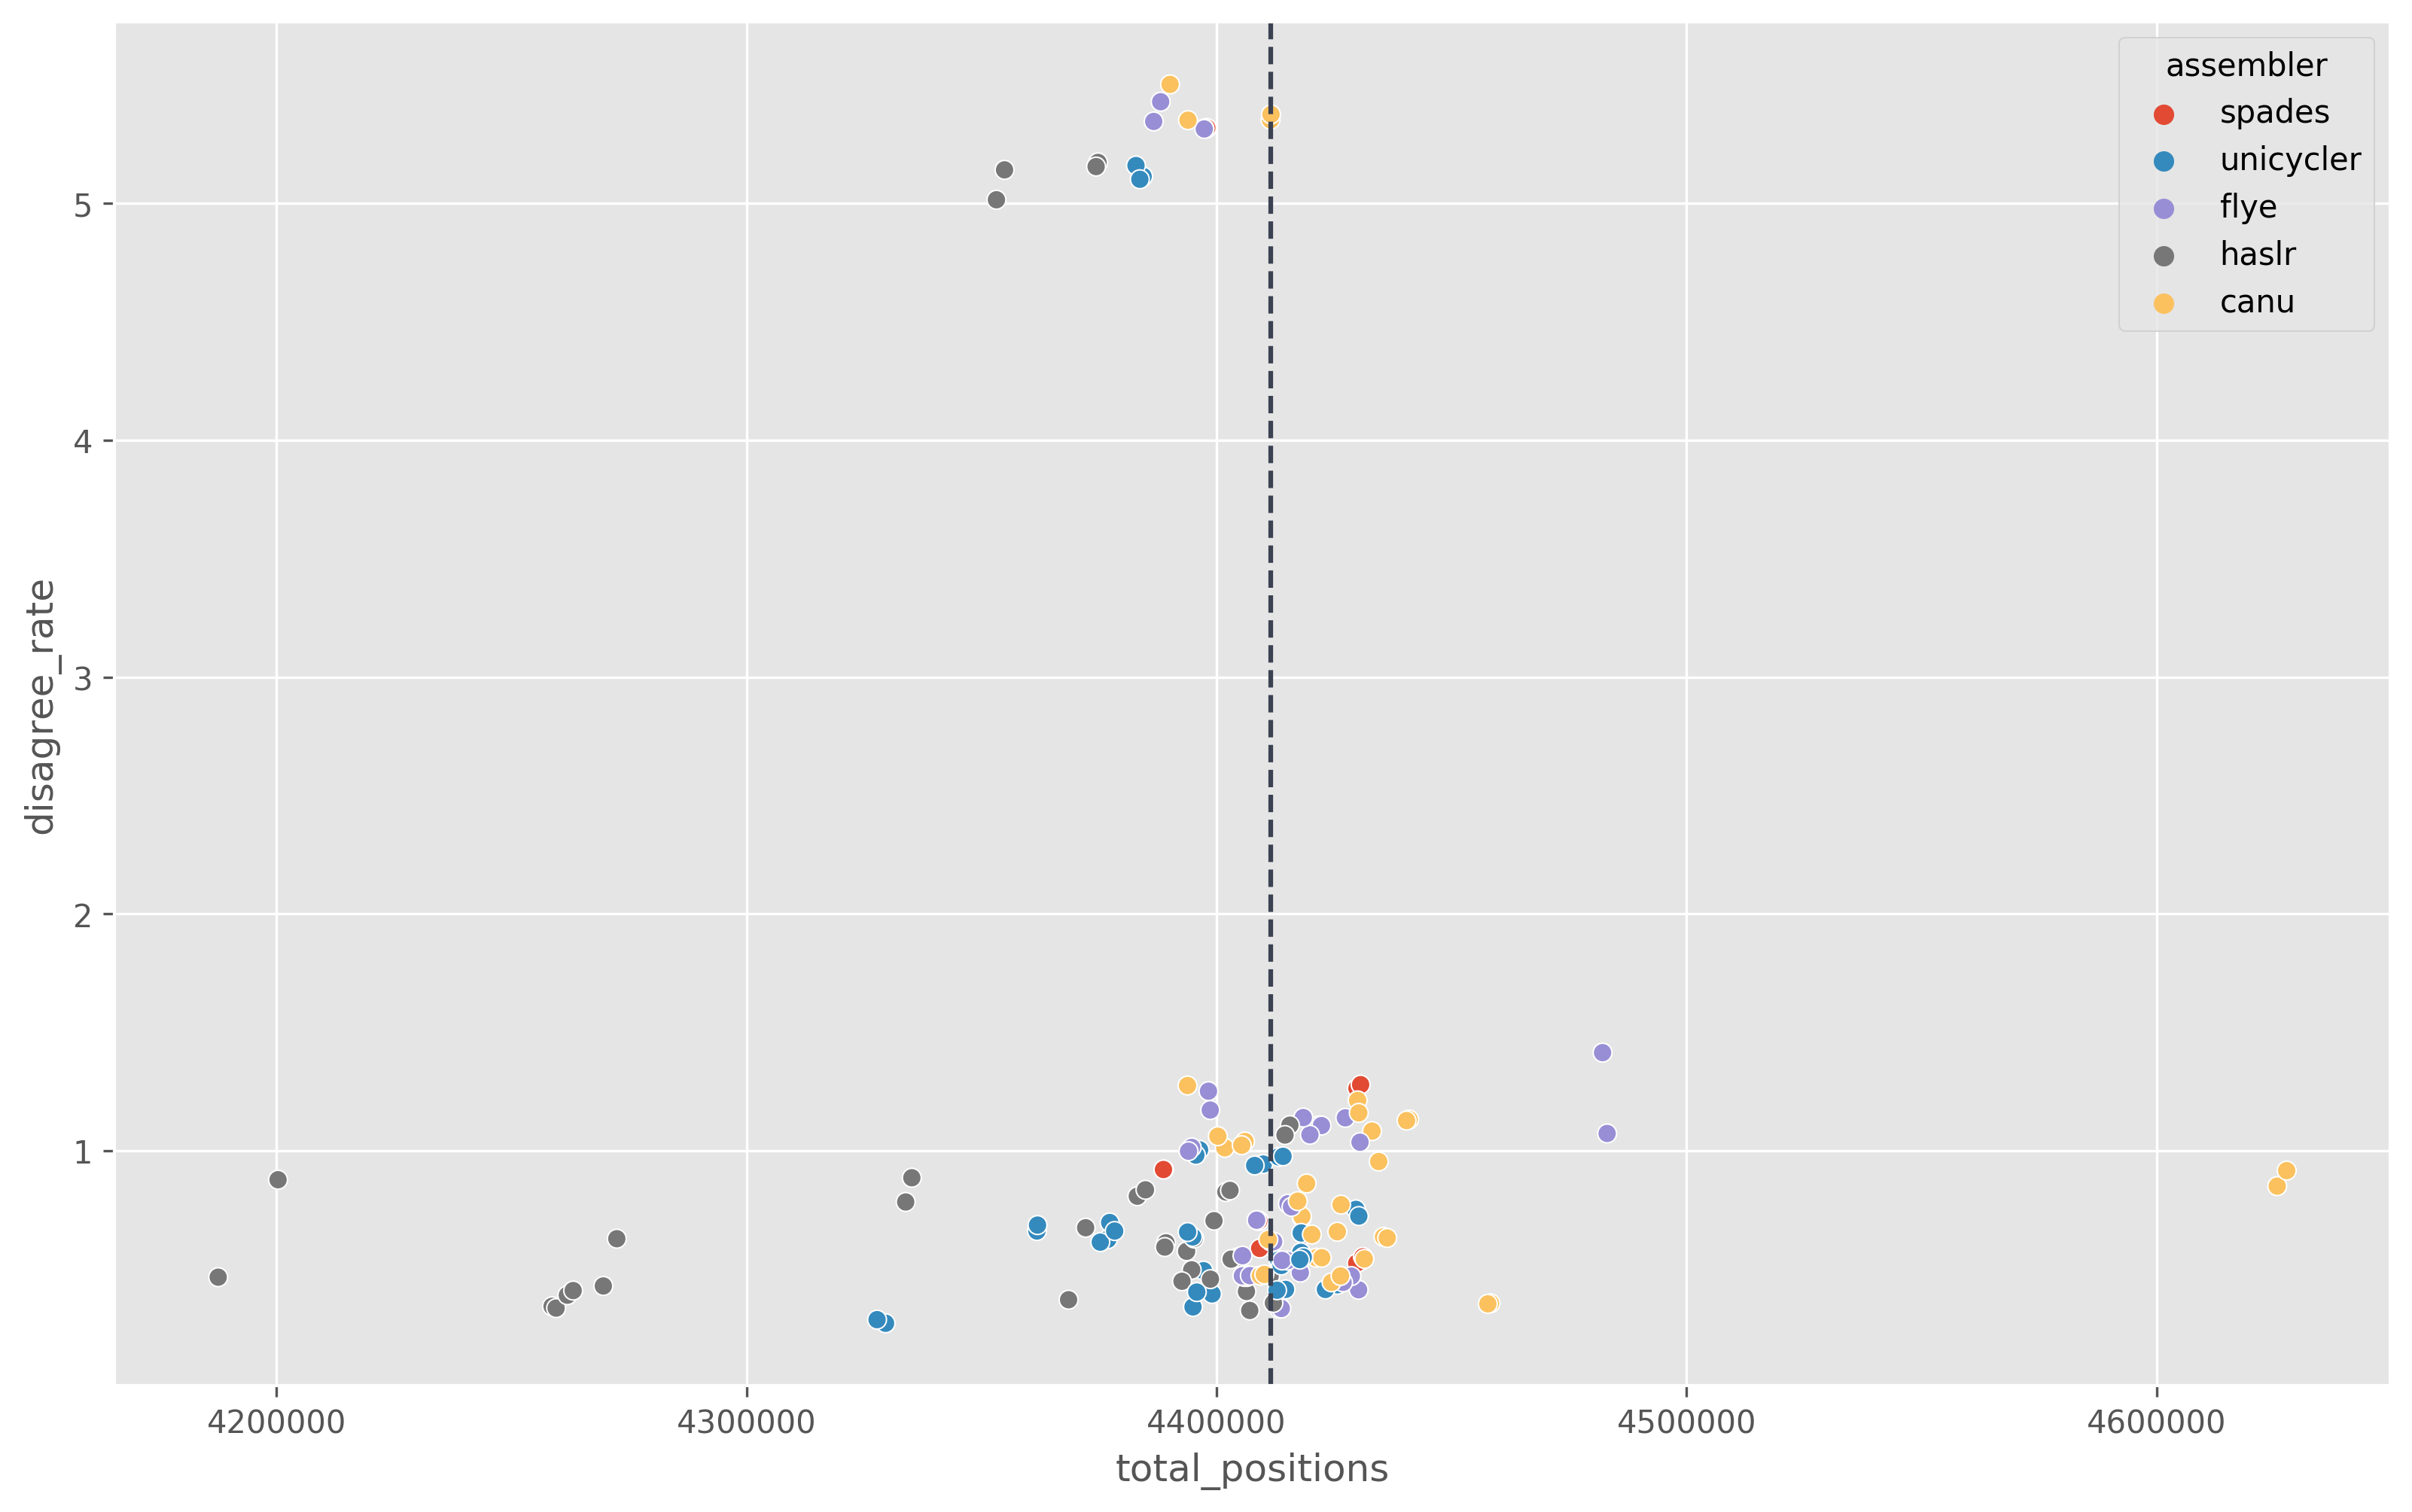

In [144]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=300)
sns.scatterplot(data=df, x="total_positions", y="disagree_rate", hue="assembler")
_ = ax.axvline(h37rv_len, ls="--", color=nord[1])

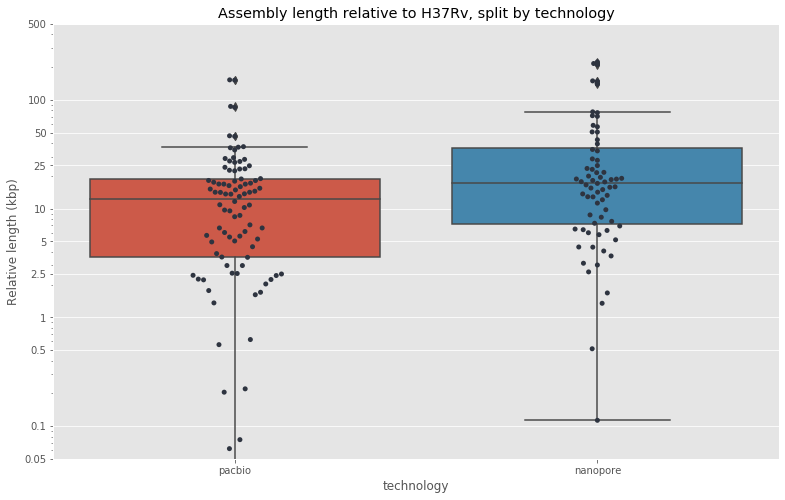

In [99]:
x = "technology"
y = "relative_total_length"
data = quast_df
title = f"Assembly length relative to H37Rv, split by {x}"
ylabel = "Relative length (kbp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

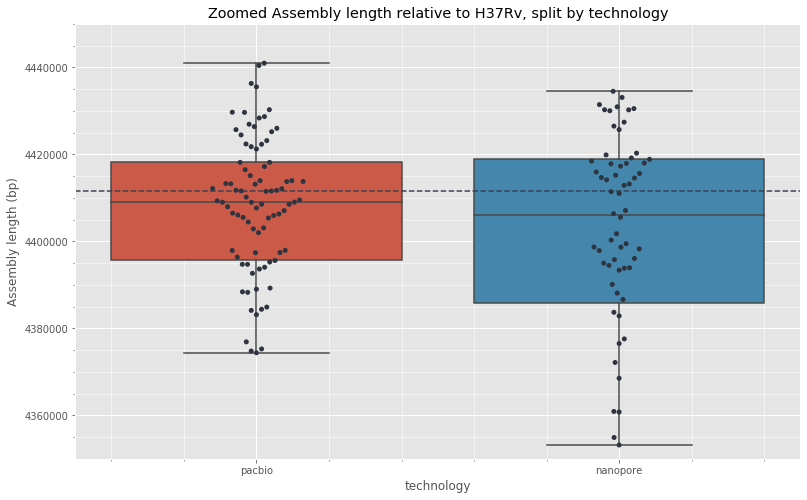

In [100]:
x = "technology"
y = "total_length"
data = quast_df
title = f"Zoomed Assembly length relative to H37Rv, split by {x}"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
_ = ax.set_ylim((4_350_000, 4_450_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

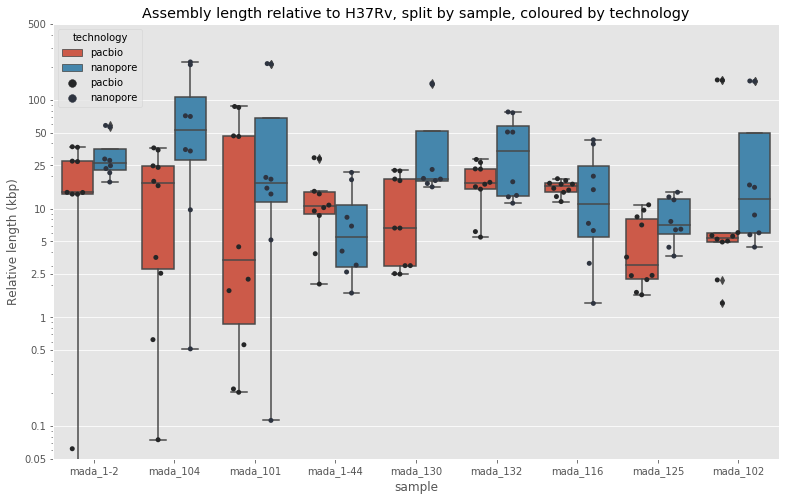

In [101]:
x = "sample"
y = "relative_total_length"
hue = "technology"
data = quast_df
title = f"Assembly length relative to H37Rv, split by {x}, coloured by {hue}"
ylabel = "Relative length (kbp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

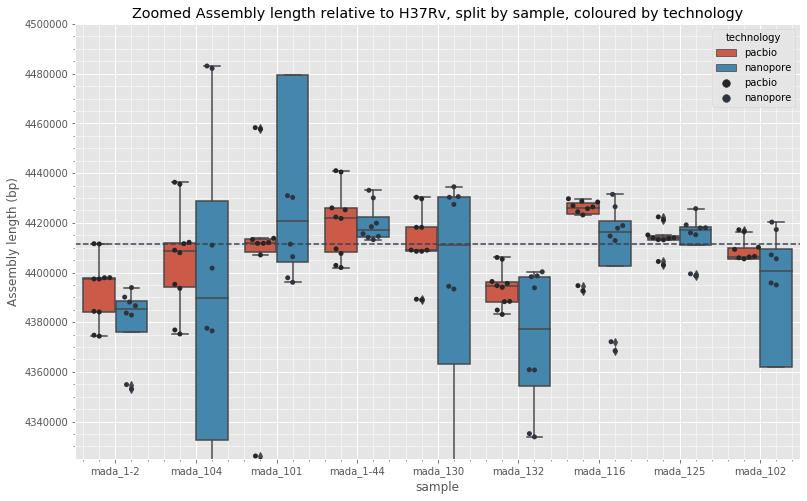

In [102]:
x = "sample"
y = "total_length"
hue = "technology"
data = quast_df
title = f"Zoomed Assembly length relative to H37Rv, split by {x}, coloured by {hue}"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
_ = ax.set_ylim((4_325_000, 4_500_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

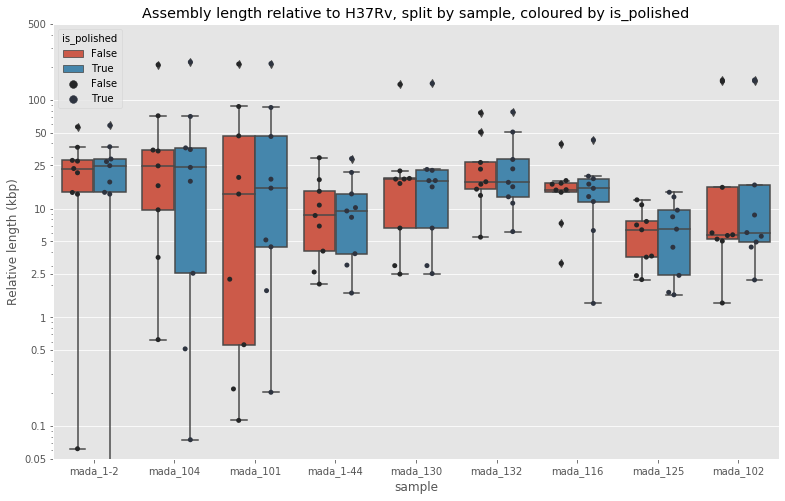

In [103]:
x = "sample"
y = "relative_total_length"
hue = "is_polished"
data = quast_df
title = f"Assembly length relative to H37Rv, split by {x}, coloured by {hue}"
ylabel = "Relative length (kbp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

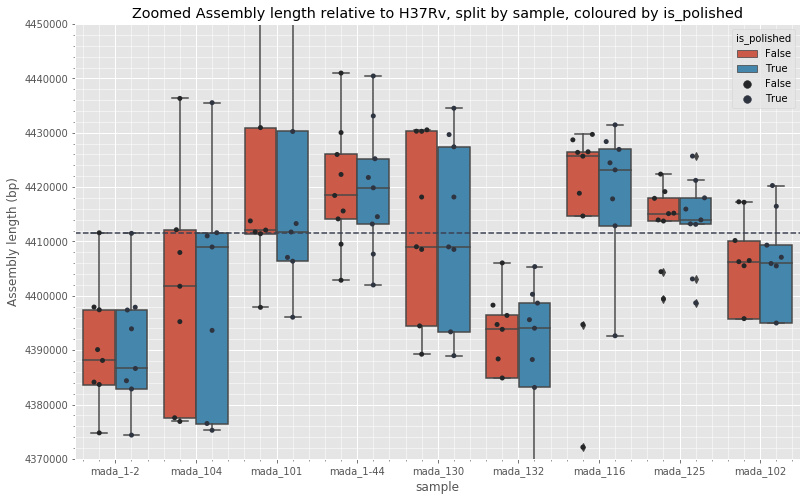

In [104]:
x = "sample"
y = "total_length"
hue = "is_polished"
data = quast_df
title = f"Zoomed Assembly length relative to H37Rv, split by {x}, coloured by {hue}"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
_ = ax.set_ylim((4_370_000, 4_450_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


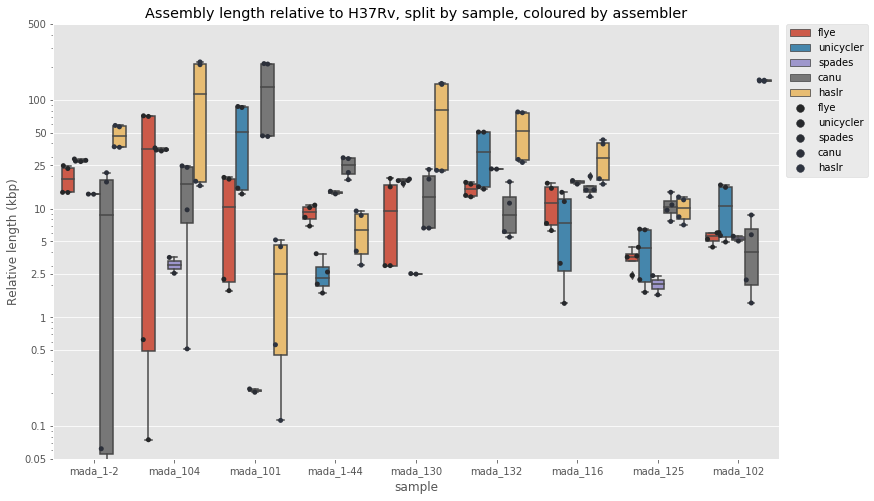

In [105]:
x = "sample"
y = "relative_total_length"
hue = "assembler"
data = quast_df
title = f"Assembly length relative to H37Rv, split by {x}, coloured by {hue}"
ylabel = "Relative length (kbp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

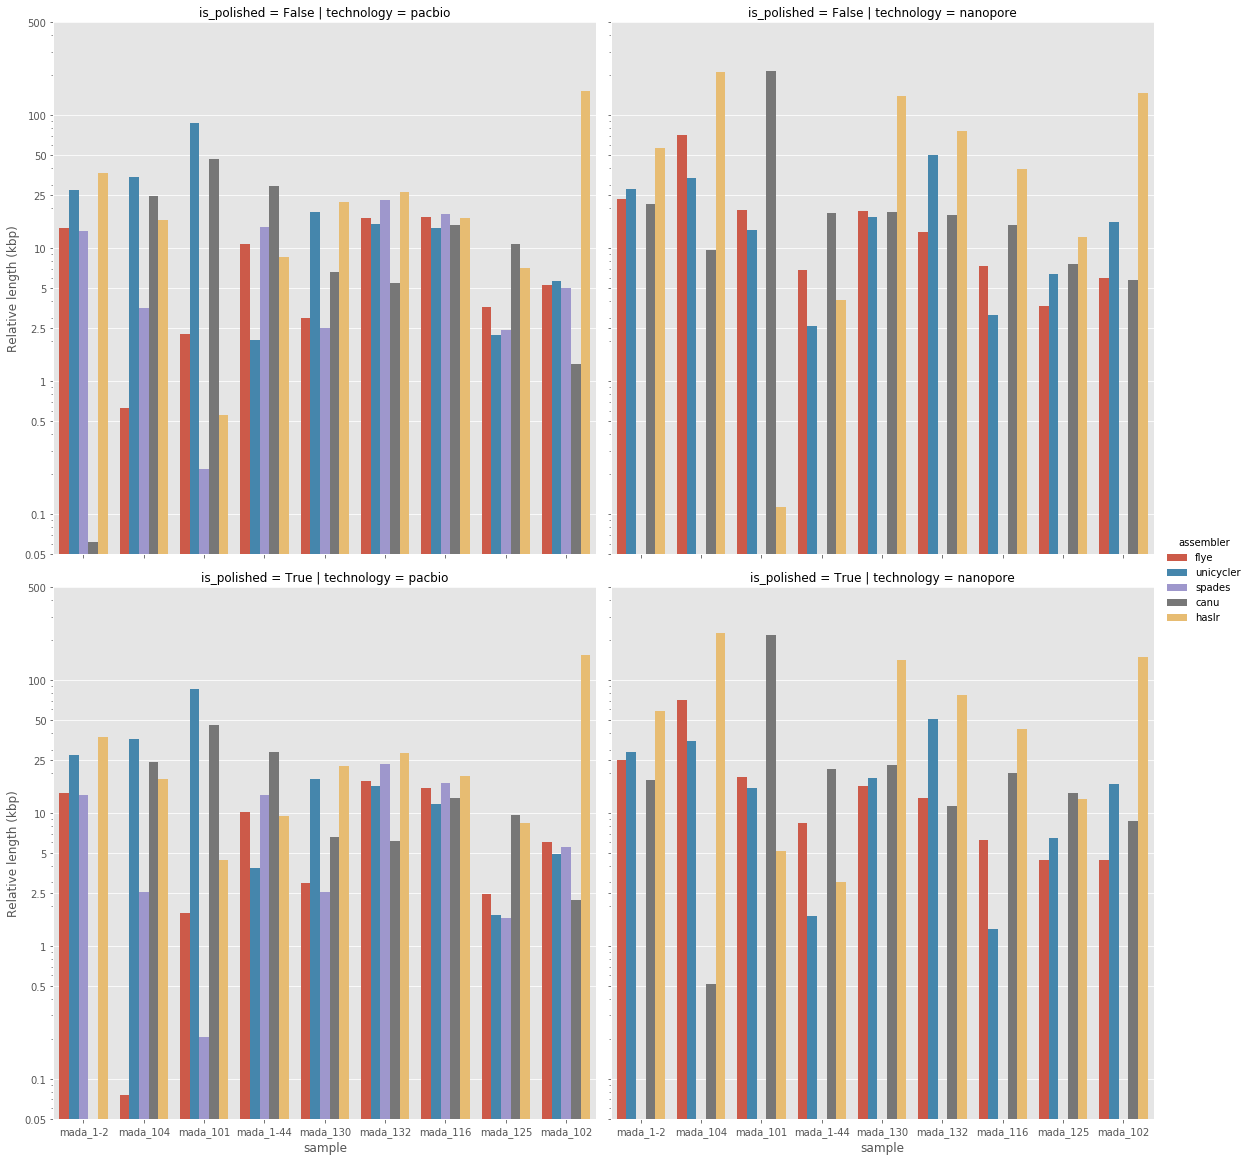

In [106]:
x = "sample"
y = "relative_total_length"
hue = "assembler"
col = "technology"
row = "is_polished"
data = quast_df
kind = "bar"
ax = sns.catplot(
    x=x, 
    y=y, 
    hue=hue,
    row=row,
    col=col,
    data=data, 
    kind=kind, 
    aspect=1, 
    height=8
)
ax.set(yscale="log")
log_ticks = [0.05, 0.1, 0.5, 1, 2.5, 5, 10, 25, 50, 100, 500]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Relative length (kbp)")
_ = ax.set_yticklabels(log_ticks)

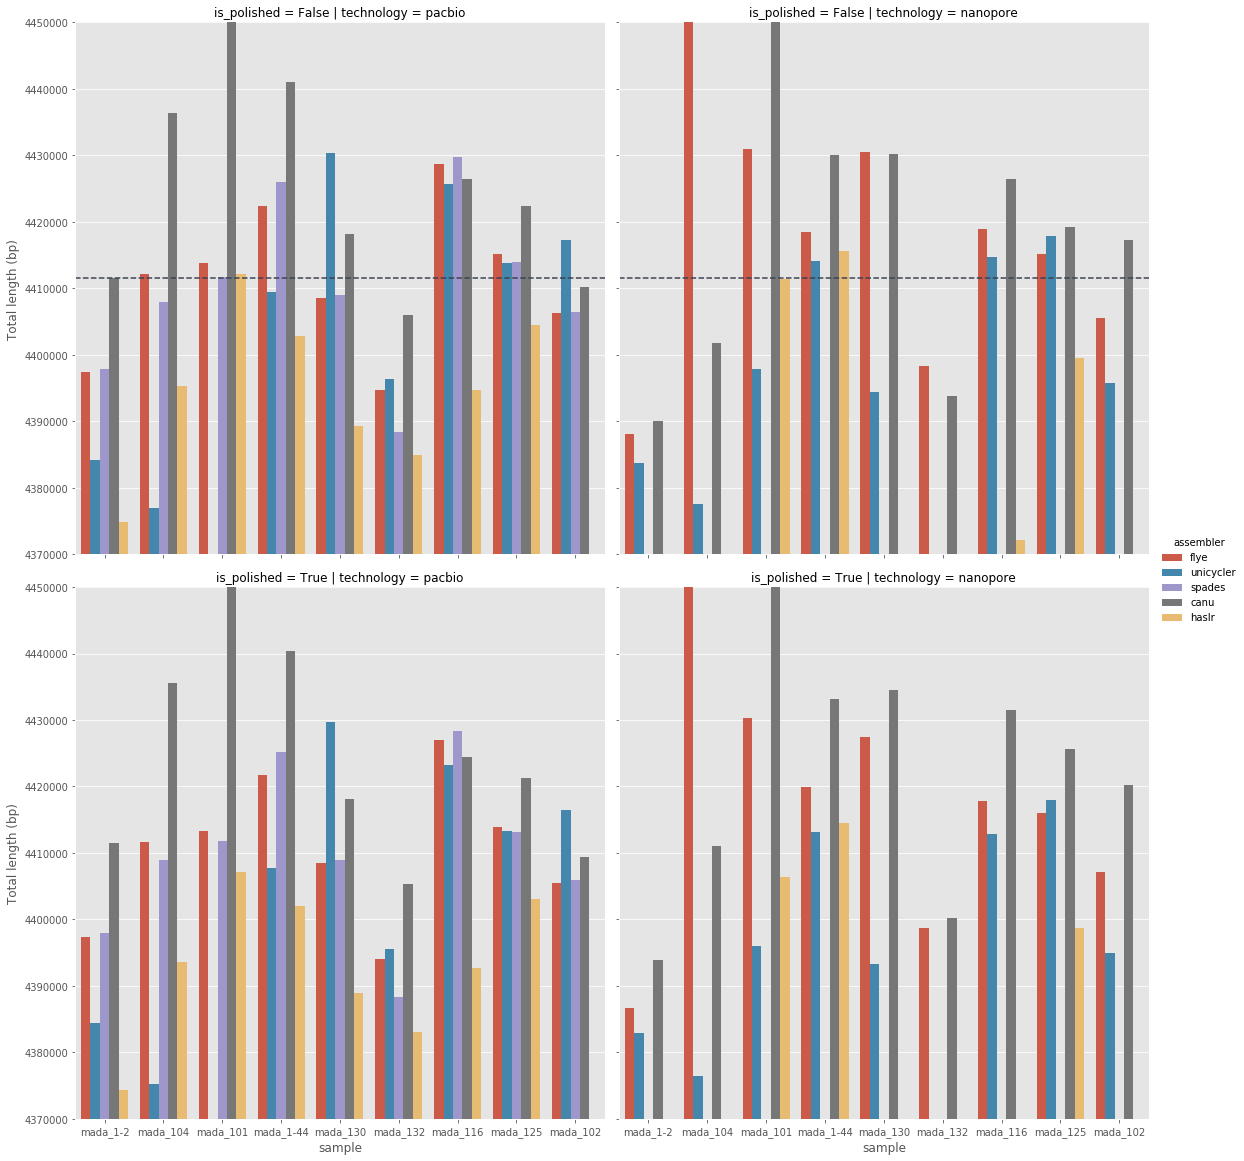

In [107]:
x = "sample"
y = "total_length"
hue = "assembler"
col = "technology"
row = "is_polished"
data = quast_df
kind = "bar"
ax = sns.catplot(
    x=x, 
    y=y, 
    hue=hue,
    row=row,
    col=col,
    data=data, 
    kind=kind, 
    aspect=1, 
    height=8
)
ylim = (4_370_000, 4_450_000)
ax.set(ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Total length (bp)")

for axis in ax.axes[0]:
    _ = axis.axhline(h37rv_len, ls="--", color=nord[1])

So what is the closest assembly length to H37Rv for each sample?

In [108]:
var = "relative_total_length"
for sample, frame in quast_df.groupby("sample"):
    print(f"------{sample}------\n")
    m = frame[var].min()
    print(f"Minimum {m} {var}")
    print(frame.query("relative_total_length == @m").groupby("assembler")["sample"].count())
# quast_df.query("contigs == 1").groupby("assembler")["sample"].count()

------mada_1-2------

Minimum 0.037 relative_total_length
assembler
canu    1
Name: sample, dtype: int64
------mada_1-44------

Minimum 1.677 relative_total_length
assembler
unicycler    1
Name: sample, dtype: int64
------mada_101------

Minimum 0.113 relative_total_length
assembler
haslr    1
Name: sample, dtype: int64
------mada_102------

Minimum 1.358 relative_total_length
assembler
canu    1
Name: sample, dtype: int64
------mada_104------

Minimum 0.075 relative_total_length
assembler
flye    1
Name: sample, dtype: int64
------mada_116------

Minimum 1.347 relative_total_length
assembler
unicycler    1
Name: sample, dtype: int64
------mada_125------

Minimum 1.615 relative_total_length
assembler
spades    1
Name: sample, dtype: int64
------mada_130------

Minimum 2.505 relative_total_length
assembler
spades    1
Name: sample, dtype: int64
------mada_132------

Minimum 5.479 relative_total_length
assembler
canu    1
Name: sample, dtype: int64


In [109]:
quast_df.loc[quast_df.groupby('sample', sort=False)['relative_total_length'].idxmin()]

,index,contigs,largest_contig,total_length,gc,avg_depth,misassemblies,mismatch_rate,indel_rate,genomic_features,sample,is_polished,assembler,technology,relative_total_length
11,canu_pb_pol,1,4411495,4411495,65.63,146,30,63.52,4.79,8304,mada_1-2,True,canu,pacbio,0.037
19,flye_pb_pol,1,4411607,4411607,65.61,452,33,62.49,7.95,8220,mada_104,True,flye,pacbio,0.075
52,haslr_ont,5,2094391,4411419,65.63,497,35,31.95,21.17,8230,mada_101,False,haslr,nanopore,0.113
61,uc_ont_pol,5,2308691,4413209,65.57,387,31,65.61,10.16,8228,mada_1-44,True,unicycler,nanopore,1.677
80,spades,1,4409027,4409027,65.63,298,49,32.40,4.90,8228,mada_130,False,spades,pacbio,2.505
100,canu_pb,1,4406053,4406053,65.61,242,34,20.24,3.02,8307,mada_132,False,canu,pacbio,5.479
115,uc_ont_pol,7,2139477,4412879,65.60,380,55,44.93,9.15,8236,mada_116,True,unicycler,nanopore,1.347
135,spades_pol,1,4413147,4413147,65.61,338,51,44.72,6.64,8210,mada_125,True,spades,pacbio,1.615
154,canu_pb,11,1052156,4410174,65.62,445,41,32.27,6.04,8246,mada_102,False,canu,pacbio,1.358


In [110]:
quast_df.loc[quast_df.groupby('sample', sort=False)['relative_total_length'].idxmin()].groupby("assembler")["sample"].count()

assembler
canu         3
flye         1
haslr        1
spades       2
unicycler    2
Name: sample, dtype: int64

In [111]:
quast_df.loc[quast_df.groupby('sample', sort=False)['relative_total_length'].idxmin()].groupby("technology")["sample"].count()

technology
nanopore    3
pacbio      6
Name: sample, dtype: int64

In [112]:
quast_df.loc[quast_df.groupby('sample', sort=False)['relative_total_length'].idxmin()].groupby("is_polished")["sample"].count()

is_polished
False    4
True     5
Name: sample, dtype: int64

In [113]:
quast_df.groupby("assembler")["relative_total_length"].sum()

assembler
canu          938.625
flye          481.204
haslr        1990.440
spades        163.026
unicycler     757.361
Name: relative_total_length, dtype: float64

## Largest contig

/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


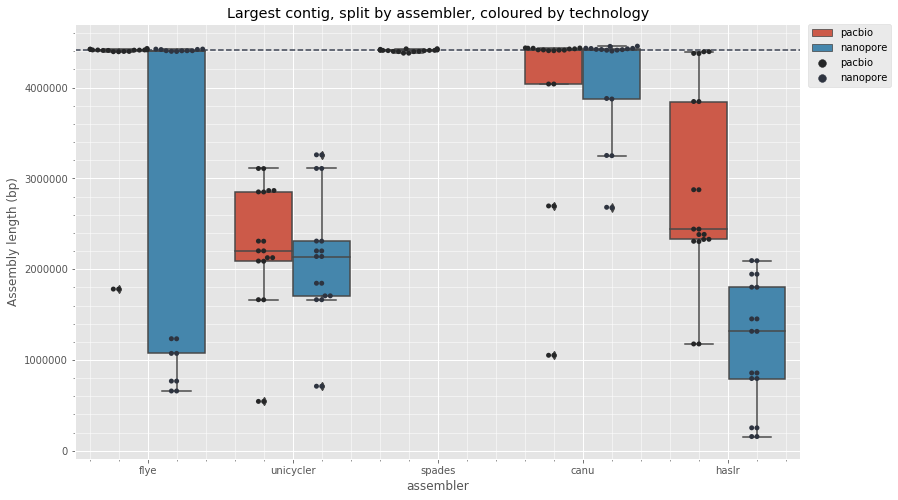

In [114]:
x = "assembler"
y = "largest_contig"
hue = "technology"
data = quast_df
title = f"Largest contig, split by {x}, coloured by {hue}"
ylabel = "Assembly length (bp)"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
_ = ax.axhline(h37rv_len, ls="--", color=nord[1])
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [115]:
quast_df.loc[quast_df.groupby('sample', sort=False)['largest_contig'].idxmax()]

,index,contigs,largest_contig,total_length,gc,avg_depth,misassemblies,mismatch_rate,indel_rate,genomic_features,sample,is_polished,assembler,technology,relative_total_length
10,canu_pb,1,4411594,4411594,65.62,146,30,23.11,3.72,8304,mada_1-2,False,canu,pacbio,0.062
28,canu_pb,1,4436317,4436317,65.60,437,34,64.70,8.37,8225,mada_104,False,canu,pacbio,24.785
49,canu_ont_pol,5,4455647,4627712,65.64,484,45,34.75,14.96,8290,mada_101,True,canu,nanopore,216.180
67,canu_ont_pol,1,4433092,4433092,65.59,386,27,64.43,11.01,8251,mada_1-44,True,canu,nanopore,21.560
80,spades,1,4409027,4409027,65.63,298,49,32.40,4.90,8228,mada_130,False,spades,pacbio,2.505
100,canu_pb,1,4406053,4406053,65.61,242,34,20.24,3.02,8307,mada_132,False,canu,pacbio,5.479
121,canu_ont_pol,1,4431450,4431450,65.63,379,52,47.50,9.84,8252,mada_116,True,canu,nanopore,19.918
139,canu_ont_pol,2,4418631,4425704,65.62,337,52,47.59,10.30,8220,mada_125,True,canu,nanopore,14.172
157,canu_ont_pol,1,4420286,4420286,65.64,444,43,34.68,8.03,8250,mada_102,True,canu,nanopore,8.754


In [116]:
quast_df.loc[quast_df.groupby('sample', sort=False)['largest_contig'].idxmax()].groupby("assembler")["sample"].count()

assembler
canu      8
spades    1
Name: sample, dtype: int64

## Misassemblies

/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


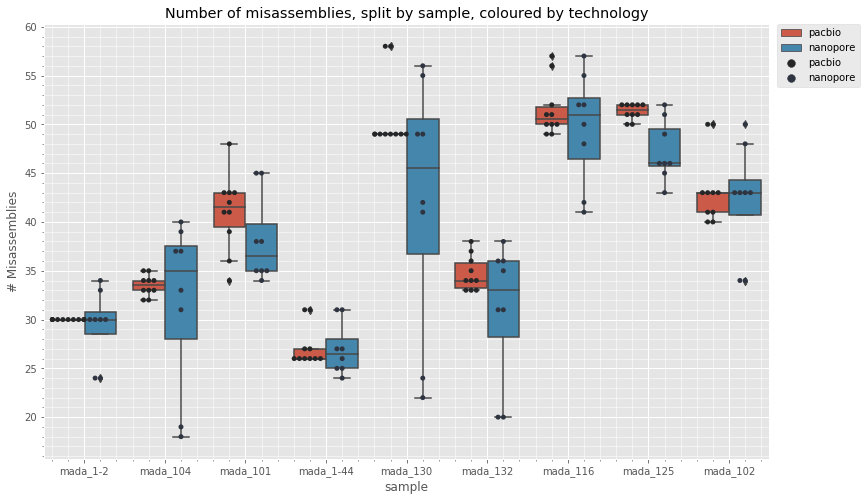

In [117]:
x = "sample"
y = "misassemblies"
hue = "technology"
data = quast_df
title = f"Number of misassemblies, split by {x}, coloured by {hue}"
ylabel = "# Misassemblies"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

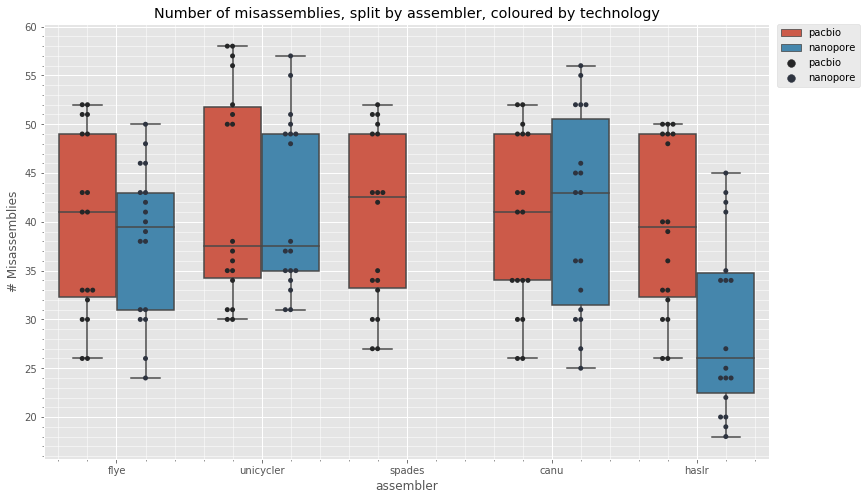

In [118]:
x = "assembler"
y = "misassemblies"
hue = "technology"
data = quast_df
title = f"Number of misassemblies, split by {x}, coloured by {hue}"
ylabel = "# Misassemblies"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

## Mismatch rate (per 100Kbp)

/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/michael/.pyenv/versions/3.8.2/envs/head_to_head_pipeline/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


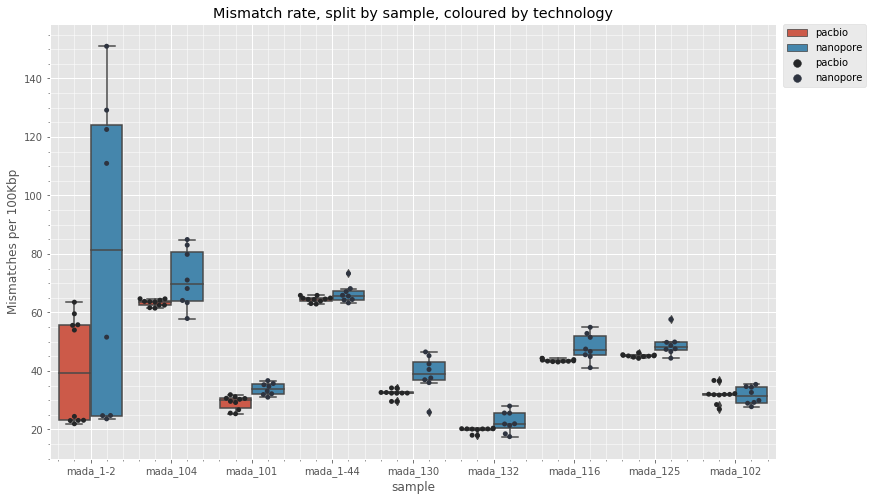

In [119]:
x = "sample"
y = "mismatch_rate"
hue = "technology"
data = quast_df
title = f"Mismatch rate, split by {x}, coloured by {hue}"
ylabel = "Mismatches per 100Kbp"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

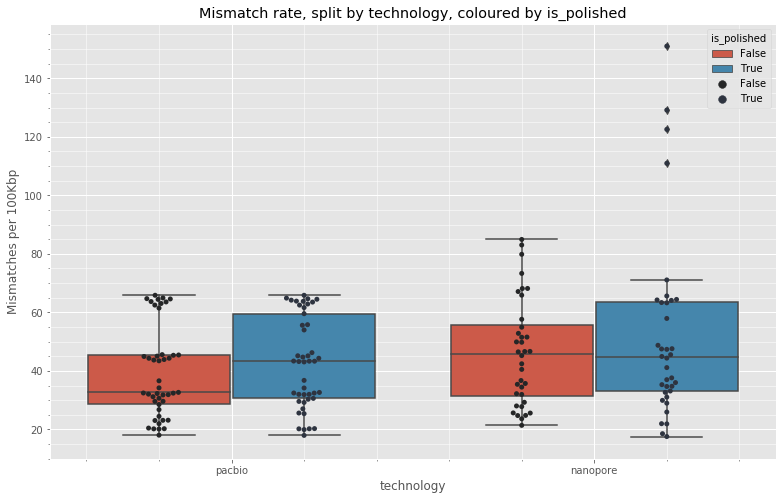

In [120]:
x = "technology"
y = "mismatch_rate"
hue = "is_polished"
data = quast_df
title = f"Mismatch rate, split by {x}, coloured by {hue}"
ylabel = "Mismatches per 100Kbp"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
# _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

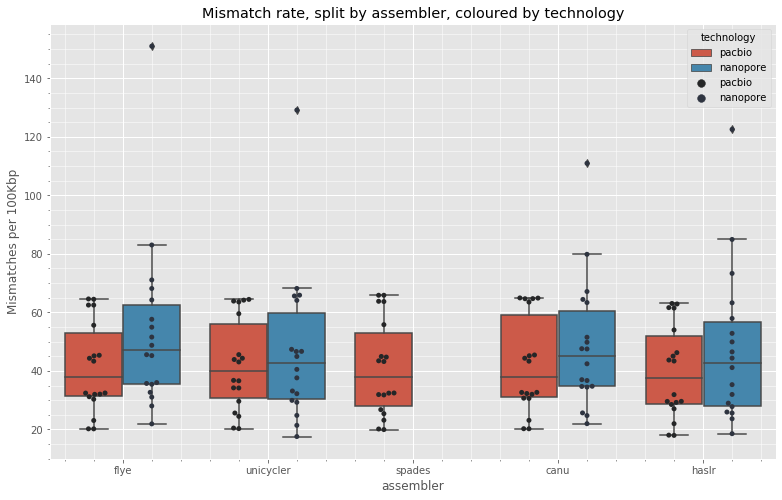

In [121]:
x = "assembler"
y = "mismatch_rate"
hue = "technology"
data = quast_df
title = f"Mismatch rate, split by {x}, coloured by {hue}"
ylabel = "Mismatches per 100Kbp"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
# _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [122]:
quast_df.loc[quast_df.groupby('sample', sort=False)['mismatch_rate'].idxmin()]

,index,contigs,largest_contig,total_length,gc,avg_depth,misassemblies,mismatch_rate,indel_rate,genomic_features,sample,is_polished,assembler,technology,relative_total_length
14,haslr_pb,2,2441393,4374785,65.60,188,30,21.96,10.28,8288,mada_1-2,False,haslr,pacbio,36.747
35,haslr_ont_pol,51,252993,4187577,65.64,457,19,57.93,8.60,7794,mada_104,True,haslr,nanopore,223.955
45,spades_pol,2,4409600,4411737,65.60,497,42,25.38,3.65,8285,mada_101,True,spades,pacbio,0.205
69,haslr_pb_pol,3,3845682,4401993,65.55,388,26,62.87,7.99,8231,mada_1-44,True,haslr,pacbio,9.539
89,haslr_ont_pol,34,795813,4269528,65.55,301,24,25.94,5.99,7950,mada_130,True,haslr,nanopore,142.004
97,uc_ont_pol,11,1845311,4360770,65.54,244,35,17.56,4.83,8261,mada_132,True,unicycler,nanopore,50.762
125,haslr_ont_pol,11,1315258,4368522,65.63,381,42,41.13,8.72,8180,mada_116,True,haslr,nanopore,43.010
131,uc_pb_pol,5,3108680,4413233,65.61,338,51,44.32,6.74,8202,mada_125,True,unicycler,pacbio,1.701
159,haslr_pb_pol,7,1176771,4258616,65.56,446,40,27.04,4.26,7992,mada_102,True,haslr,pacbio,152.916


In [123]:
quast_df.loc[quast_df.groupby('sample', sort=False)['mismatch_rate'].idxmin()].groupby("assembler")["sample"].count()

assembler
haslr        6
spades       1
unicycler    2
Name: sample, dtype: int64

In [124]:
quast_df.loc[quast_df.groupby('sample', sort=False)['mismatch_rate'].idxmin()].groupby("technology")["sample"].count()

technology
nanopore    4
pacbio      5
Name: sample, dtype: int64

In [125]:
quast_df.loc[quast_df.groupby('sample', sort=False)['mismatch_rate'].idxmin()].groupby("is_polished")["sample"].count()

is_polished
False    1
True     8
Name: sample, dtype: int64

## Indel rate (per 100Kbp)

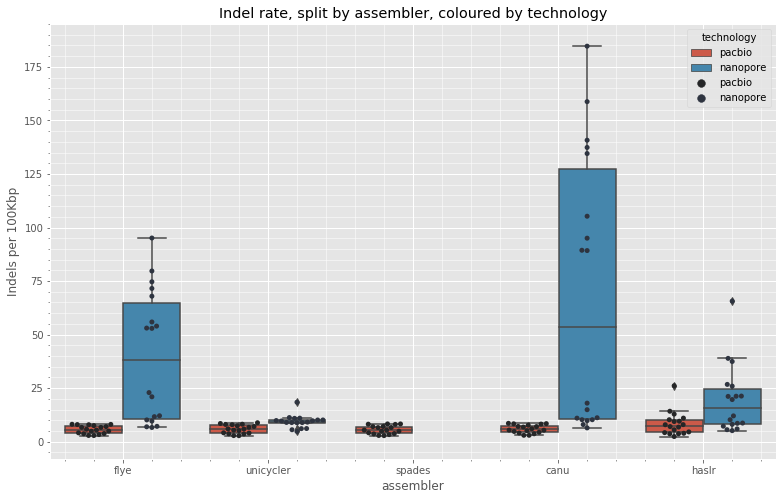

In [126]:
x = "assembler"
y = "indel_rate"
hue = "technology"
data = quast_df
title = f"Indel rate, split by {x}, coloured by {hue}"
ylabel = "Indels per 100Kbp"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
# _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

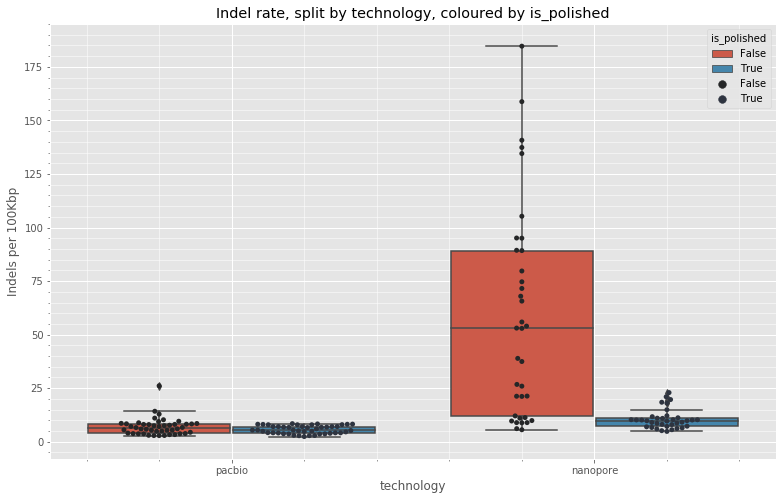

In [127]:
x = "technology"
y = "indel_rate"
hue = "is_polished"
data = quast_df
title = f"Indel rate, split by {x}, coloured by {hue}"
ylabel = "Indels per 100Kbp"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=data, 
    ax=ax,
    dodge=True,
    color=nord[0]
)
ax.set(title=title)
_ = ax.set_ylabel(ylabel)
# _ = ax.set_ylim((4_250_000, 4_550_000))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)
# Put the legend out of the figure
# _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [128]:
quast_df.loc[quast_df.groupby('sample', sort=False)['indel_rate'].idxmin()]

,index,contigs,largest_contig,total_length,gc,avg_depth,misassemblies,mismatch_rate,indel_rate,genomic_features,sample,is_polished,assembler,technology,relative_total_length
8,spades,1,4397933,4397933,65.62,146,30,23.15,3.33,8301,mada_1-2,False,spades,pacbio,13.599
33,haslr_pb_pol,1,4393641,4393641,65.61,452,33,61.63,7.94,8184,mada_104,True,haslr,pacbio,17.891
41,uc_pb_pol,53,543943,4326172,65.55,500,36,25.60,3.60,8050,mada_101,True,unicycler,pacbio,85.360
59,uc_pb_pol,6,2307974,4407675,65.57,388,31,63.86,7.94,8221,mada_1-44,True,unicycler,pacbio,3.857
87,haslr_pb_pol,2,2874723,4388989,65.59,298,49,29.57,4.60,8206,mada_130,True,haslr,pacbio,22.543
105,haslr_pb_pol,2,4373817,4383143,65.57,243,33,17.96,2.43,8298,mada_132,True,haslr,pacbio,28.389
117,spades_pol,2,4426181,4428372,65.62,380,51,43.20,7.07,8255,mada_116,True,spades,pacbio,16.840
134,spades,1,4413957,4413957,65.61,338,52,44.93,6.62,8210,mada_125,False,spades,pacbio,2.425
159,haslr_pb_pol,7,1176771,4258616,65.56,446,40,27.04,4.26,7992,mada_102,True,haslr,pacbio,152.916


In [129]:
quast_df.loc[quast_df.groupby('sample', sort=False)['indel_rate'].idxmin()].groupby("assembler")["sample"].count()

assembler
haslr        4
spades       3
unicycler    2
Name: sample, dtype: int64

In [130]:
quast_df.loc[quast_df.groupby('sample', sort=False)['indel_rate'].idxmin()].groupby("technology")["sample"].count()

technology
pacbio    9
Name: sample, dtype: int64

In [131]:
quast_df.loc[quast_df.groupby('sample', sort=False)['indel_rate'].idxmin()].groupby("is_polished")["sample"].count()

is_polished
False    2
True     7
Name: sample, dtype: int64

# Mapping quality statistics
This section will look at the mapping quality scores from the Illumina reads mapped to their respective assemblies.

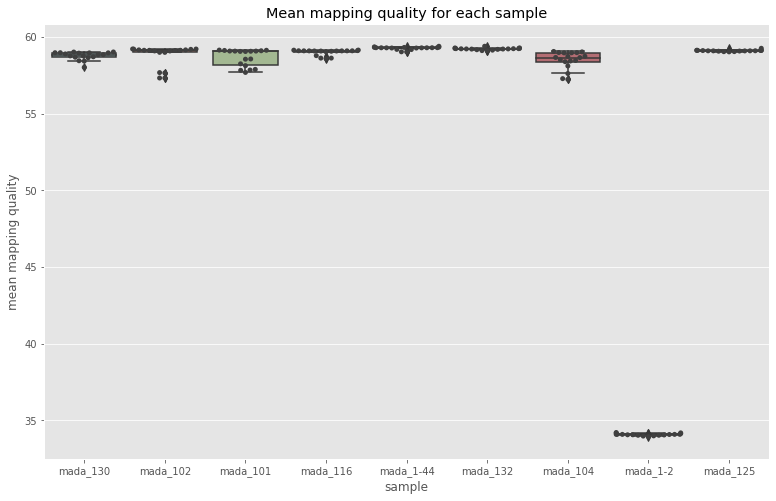

In [105]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mean mapping quality for each sample")
_ = ax.set_ylabel("mean mapping quality")

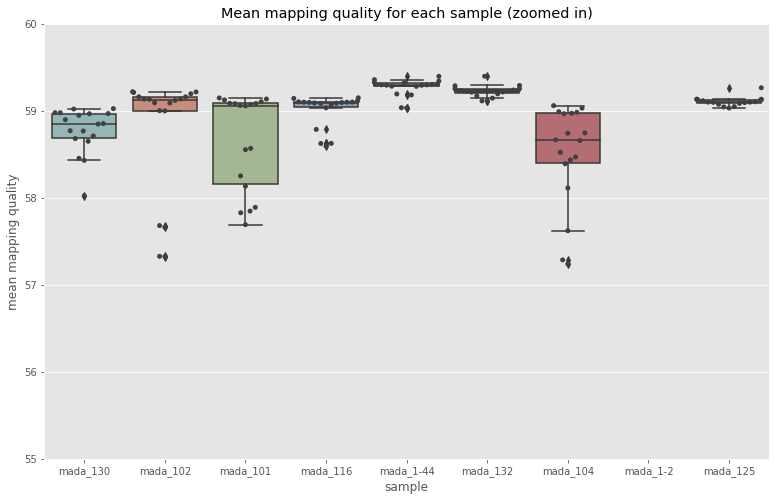

In [106]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mean mapping quality for each sample (zoomed in)")
_ = ax.set_ylabel("mean mapping quality")
_ = ax.set_ylim((55, 60))

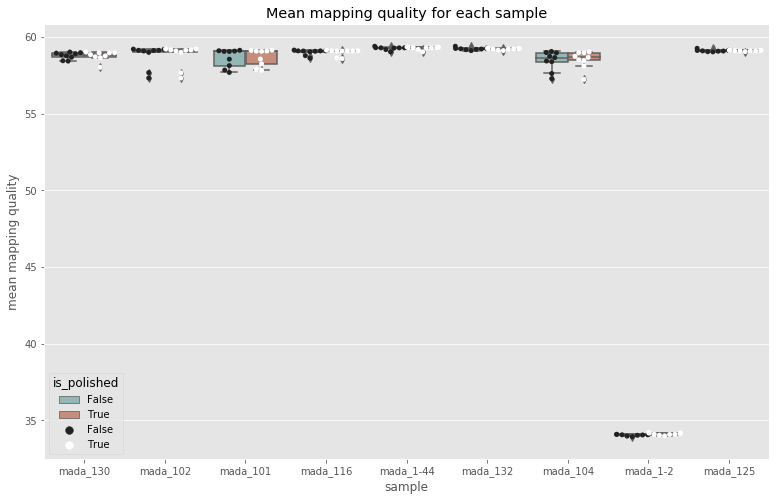

In [107]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Mean mapping quality for each sample")
_ = ax.set_ylabel("mean mapping quality")

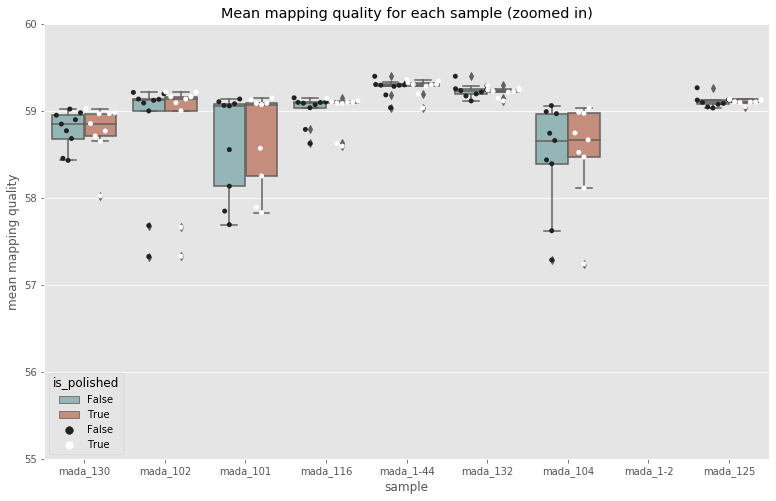

In [108]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Mean mapping quality for each sample (zoomed in)")
_ = ax.set_ylabel("mean mapping quality")
_ = ax.set_ylim((55, 60))

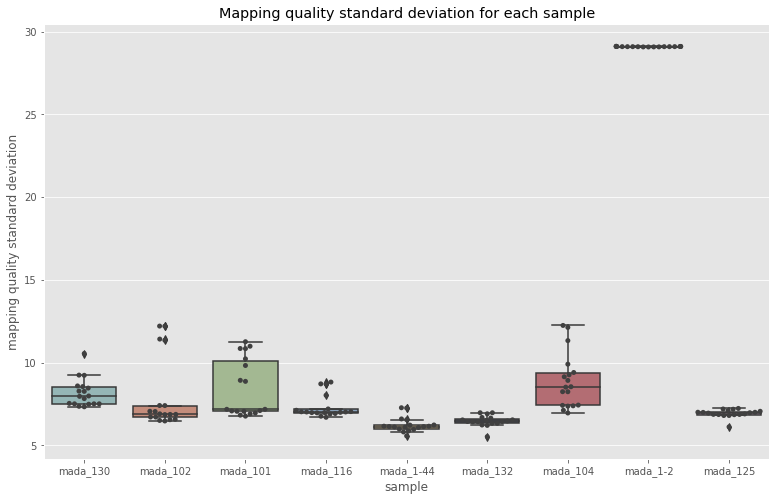

In [109]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_stdev", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_stdev", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mapping quality standard deviation for each sample")
_ = ax.set_ylabel("mapping quality standard deviation")

In [149]:
sample = "mada_125"
tech = "pacbio"

In [150]:
df.query("sample == @sample and technology == @tech and is_polished == False")

,sample,assembler,technology,is_polished,ale_score,disagree_rate,disagreements,total_positions,mapq_mean,mapq_stdev,norm_ale_score
145,mada_125,unicycler,pacbio,False,-1.889919e+07,0.515751,22764,4413761,59.087557,7.061753,4.191033e+05
149,mada_125,canu,pacbio,False,-1.876664e+07,0.548391,24252,4422389,59.047084,7.200379,2.865575e+05
152,mada_125,haslr,pacbio,False,-2.003540e+07,0.549559,24205,4404442,59.099443,7.001875,1.555314e+06
157,mada_125,flye,pacbio,False,-1.856955e+07,0.536316,23679,4415120,59.131411,6.871000,8.946371e+04
161,mada_125,spades,pacbio,False,-1.854804e+07,0.536593,23685,4413957,59.130702,6.875517,6.795599e+04


In [151]:
quast_df.query("sample == @sample and technology == @tech and is_polished == False")

,index,contigs,largest_contig,total_length,gc,avg_depth,misassemblies,mismatch_rate,indel_rate,genomic_features,sample,is_polished,assembler,technology,relative_total_length
144,flye_pb,1,4415120,4415120,65.61,337,51,45.34,6.69,8213,mada_125,False,flye,pacbio,3.588
148,uc_pb,5,3107923,4413761,65.61,338,52,45.56,8.87,8204,mada_125,False,unicycler,pacbio,2.229
152,spades,1,4413957,4413957,65.61,338,52,44.93,6.62,8210,mada_125,False,spades,pacbio,2.425
154,canu_pb,2,4415202,4422389,65.61,337,52,45.44,7.15,8211,mada_125,False,canu,pacbio,10.857
158,haslr_pb,4,2383048,4404442,65.62,339,50,45.05,9.44,8184,mada_125,False,haslr,pacbio,7.090
